In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import random
import copy
import networkx as nx
import torch
from open_spiel.python.algorithms import random_agent

import sys
sys.path.append("../")
#from utils.reinforcement_learning.dqn_HD import DQN
from utils.reinforcement_learning.dqn import DQN
from utils.params import Params
from utils.evaluation.evaluationhelper import EvaluateModel,EvaluateACTION
from utils.validation import get_Validation, area_under_curve
from utils.environment.game import GraphGame
from utils.environment.envhelper import reset
from utils.reinforcement_learning.rl_environment import Environment

def input_graph(graph_path,file):
    fh = open(graph_path+str(file)+".txt", "rb")
    GRAPH = nx.read_edgelist(fh)
    fh.close()
    nodes = GRAPH.nodes()
    map = {n:int(i) for i, n in enumerate(nodes)}
    GRAPH = reset(nx.relabel_nodes(GRAPH, map))  
    GRAPH.remove_edges_from(nx.selfloop_edges(GRAPH))
    return GRAPH, map

def implement_GNN(model,parameter_path,GRAPH):
    params = Params(parameter_path)
    game = "graph_attack_defend"
    env = Environment(game)
    num_actions = env.action_spec()["num_actions"]
    attacker = DQN(player_id=0,
                    state_representation_size=params.centrality_features,
                    hidden_layers_sizes= params.hidden_layers,
                   global_feature_size =params.global_features,
                   num_actions=num_actions)
    attacker._q_network.load_state_dict(model["_q_network"])
    attacker._optimizer.load_state_dict(model["_optimizer"])
    agents = [attacker]
    rewards, lcc, actions = EvaluateModel(env, agents,GRAPH)
    '''agents = [random_agent.RandomAgent(player_id=0, num_actions=num_actions),random_agent.RandomAgent(player_id=1, num_actions=num_actions)]
        rewards_random, lcc_random, _ = eval_model(env, agents)'''
    return rewards, lcc, actions

def implement_random_GNN(agents,GRAPH):
    game = "graph_attack_defend"
    env = Environment(game)
    num_actions = env.action_spec()["num_actions"]
    rewards, lcc, actions = EvaluateModel(env, agents,GRAPH)
    return rewards, lcc, actions
    
def implement_Bench(fname,GRAPH, map):
    game = "graph_attack_defend"
    env = Environment(game)
    num_actions = env.action_spec()["num_actions"]
    action_list = np.loadtxt(fname, dtype=int)
    action_list= [map.get(str(a)) for a in action_list]
    rewards, lcc, actions = EvaluateACTION(env, action_list,GRAPH)
    return rewards, lcc, actions


def visual_evaluation(graph_path,file_list,attacker_ba, attacker_mix):    
    AUC  = []
    for graph_name in file_list:
        GRAPH, map = input_graph(graph_path,graph_name)
        N = len(GRAPH)
        
        # Trained MIXED
        rewards_mix, lcc_mix, actions_mix = implement_GNN(attacker_mix[0],attacker_mix[1],GRAPH.copy())
        # Trained BA
        rewards_ba, lcc_ba, actions_ba = implement_GNN(attacker_ba[0],attacker_ba[1],GRAPH.copy())
        print(graph_name)
        print(actions_mix)
        print(actions_ba)
        
        #FINDER MODEl
        #FINDER Best Re-Trained  iteration
        path = "./FINDER/FINDER_ReTrained/"
        fname = path+graph_name+".txt"
        if os.path.exists(fname):
            rewards_Finder, lcc_Finder, actions = implement_Bench(fname,GRAPH.copy(),map)
        else:
            lcc_Finder = None
        #CI
        path = "./CI/"
        fname = path+graph_name+".txt"
        rewards_CI, lcc_CI, actions = implement_Bench(fname,GRAPH.copy(),map)
        
        #CoreHD
        path = "./CoreHD/"
        fname = path+graph_name+".txt"
        rewards_CoreHD, lcc_CoreHD, actions =  implement_Bench(fname,GRAPH.copy(),map)
        
        '''#Random
        attacker = random_agent.RandomAgent(player_id=1, num_actions=N)
        rewards_random, lcc_random, actions_random = implement_random_GNN([attacker,attacker],GRAPH.copy())'''


        x =  np.flip(np.arange(N)[N:0:-1]/N)
        
        #Plot LCC Decrease
        plt.plot(x[:len(lcc_mix)],np.array(lcc_mix)/N, 'green',label='Trained Attacker')
        plt.plot(x[:len(lcc_ba)],np.array(lcc_ba)/N, 'red',label='Trained Attacker [BA model]')
        if lcc_Finder != None:
            plt.plot(x[:len(lcc_Finder)],np.array(lcc_Finder)/N, 'aquamarine',label='FINDER ReTrained')
        plt.plot(x[:len(lcc_CI)],np.array(lcc_CI)/N, 'pink',label='CI')
        plt.plot(x[:len(lcc_CoreHD)],np.array(lcc_CoreHD)/N, 'brown',label='CoreHD')
        #plt.plot(x[:len(lcc_random)],np.array(lcc_random)/N, 'blue',label='Random')
        plt.xlabel("Fraction of Nodes Removed")
        plt.ylabel("LCC/No. of Nodes")
        plt.legend()
        plt.title("LCC vs No. of Nodes for Agents  -"+ graph_name +" Dataset")
        plt.savefig("./Figure/LCC_vs_No_Nodes_"+graph_name)
        plt.show()
        plt.clf()
        ## Plot Reward
        plt.plot(np.cumsum(rewards_mix), 'green',label='Trained Attacker')
        plt.plot(np.cumsum(rewards_ba), 'red',label='Trained Attacker [BA model]')
        if lcc_Finder != None:
            plt.plot(np.cumsum(rewards_Finder), 'aquamarine',label='FINDER ReTrained')
        plt.plot(np.cumsum(rewards_CI), 'pink',label='CI')
        plt.plot(np.cumsum(rewards_CoreHD), 'brown',label='CoreHD')
        #plt.plot(np.cumsum(rewards_random), 'blue',label='Random')
        plt.legend()
        plt.title("Rewards for Agents -"+ graph_name +" Dataset")
        plt.savefig("./Figure/Rewards_"+graph_name)
        plt.show()
        
        #Compute Area under the curve
        auc_mix = area_under_curve(x[:len(lcc_mix)],lcc_mix)
        auc_ba =  area_under_curve(x[:len(lcc_ba)],lcc_ba)
        if lcc_Finder != None:
            auc_Finder = area_under_curve(x[:len(lcc_Finder)],lcc_Finder)
        auc_CI = area_under_curve(x[:len(lcc_CI)],lcc_CI)
        auc_CoreHD = area_under_curve(x[:len(lcc_CoreHD)],lcc_CoreHD)
        if lcc_Finder != None:
            auc_all = np.array([auc_mix,auc_ba,auc_Finder,auc_CI,auc_CoreHD],dtype='O')
        else:
            auc_all = np.array([auc_mix,auc_ba,None,auc_CI,auc_CoreHD],dtype='O')
            
        #auc_all = np.array([auc_Finder,auc_CI,auc_CoreHD],dtype='O')
        AUC.append(np.insert(auc_all,0,graph_name))
    AUC = np.array(AUC)
    return AUC

# Results

In [8]:
BA = 59000 #Hetero 348500#Tree 476000# Tree 299500 
MIX = 461500 #Hetero 5000 #Tree 1000 # Tree 59500 
parameter = ["./utils/ba_params.json","./utils/mixed_params.json"]
attacker= [torch.load('./model/DiffSize_BA_Graph_HDgreedy_CI/DiffSize_BA_Graph/model_BAGraph_'+str(BA)),torch.load('./model/DiffSize_Different_Graph_HDgreedy_CI/DiffSize_Different_Graph/model_differentGraph_'+str(MIX))]


# Real World Network

test
[2, 4, 3, 6, 1, 12]
[0, 3, 6, 16, 1]


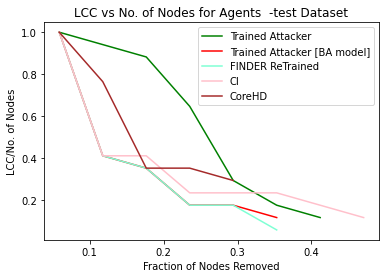

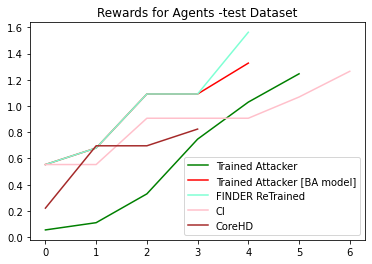

testTrain
[4, 26, 0, 8, 11, 27, 5, 19, 2, 1, 9, 33, 30, 28, 45, 39, 3, 10, 38, 32, 14, 35]
[4, 48, 49, 0, 26, 5, 8, 27, 9, 20, 3, 1, 33, 45, 32, 16, 29, 14, 10]


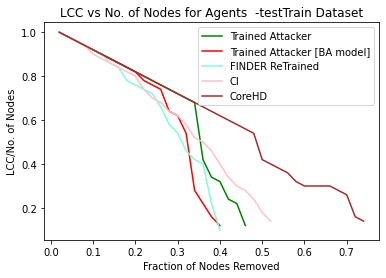

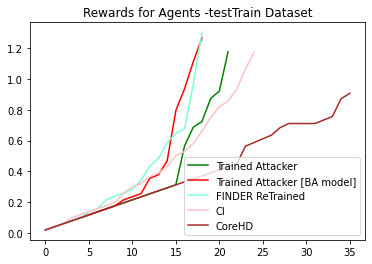

KeyboardInterrupt: 

In [39]:
file_list = ['HI-II-14','bio-grid-human']#['Digg_LCC']#['Gnutella31']
#file_list = ['GeneInteraction','ReliableInteraction']#['Gnutella31']bio-grid-human.txt
file_list = ["test","testTrain","corruption","foodweb-baywet","inf-USAir97","moreno_crime_projected",'opsahl-openflights','household','faa','facebook','powergrid','netscience','HI-II-14']
graph_path =  "./Dataset/Real/"
AUC = visual_evaluation(graph_path,file_list,[attacker[0],parameter[0]],[attacker[1],parameter[1]])


In [41]:
file = ['differentGraph','BAGraph','FinderReTrained','CI','Core']
print('Test Name','\t\t','Mix','\t','BA','\t','FIN','\t','CI','\t','Core','\t','BEST')
for i, element in enumerate(AUC):
    for nested_tem in element:
        if isinstance(nested_tem, str): 
            print(nested_tem, end=" => \t")
        else:
            print("{:.2f}".format(nested_tem), end=" \t")
    
    best = np.argmin(np.array(element[1:]).astype(float))
    print(file[best])
    print("")
print("===============================")

Test Name 		 Mix 	 BA 	 FIN 	 CI 	 Core 	 BEST
tree_8_80_grid_4 => 	641.86 	580.90 	610.63 	285.49 	1218.18 	CI

tree_8_100_grid_5 => 	792.61 	770.72 	784.45 	371.55 	1487.73 	CI



# Synthetic Network:- Heterogeneity and Homogeneity

heterogeneous_30
[3, 13, 20, 15, 2, 21, 10]
[8, 10, 15, 2, 21, 3, 12]


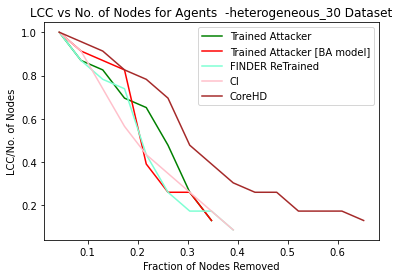

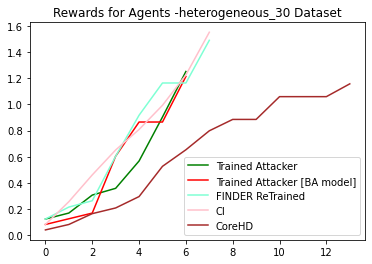

heterogeneous_50
[3, 11, 12, 29, 26, 10, 16, 22, 25, 6]
[11, 12, 35, 25, 10, 3, 16, 22, 26, 31, 6]


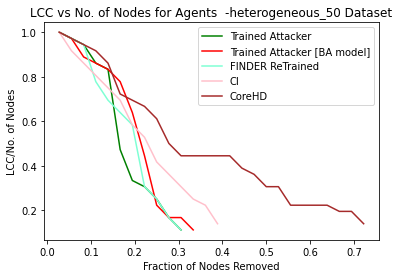

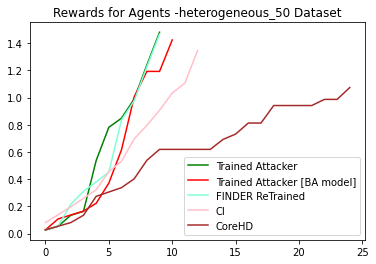

heterogeneous_100
[74, 54, 9, 71, 31, 50, 11, 29, 35, 30, 1, 13, 48, 45]
[74, 54, 31, 35, 71, 9, 14, 13, 50, 30, 11, 1, 58, 57, 48, 29]


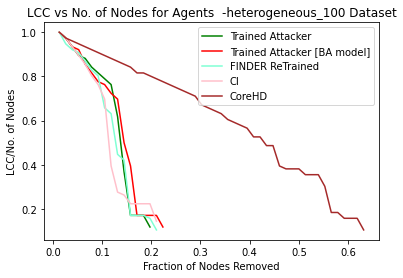

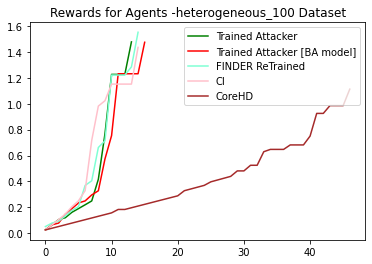

heterogeneous_500
[411, 407, 245, 103, 154, 150, 98, 109, 263, 148, 198, 152, 261, 363, 195, 254, 225, 214, 253, 260, 380, 306, 197, 281, 173, 278, 1, 338, 352, 252, 112, 286, 18, 219, 45, 107, 136, 130, 104, 129, 275, 398, 247, 34, 243, 251, 133, 2, 28, 279, 244, 264, 32, 256, 88, 383, 240, 42, 91]
[407, 411, 98, 263, 245, 198, 150, 171, 154, 261, 103, 152, 148, 214, 195, 109, 363, 260, 281, 275, 306, 253, 380, 173, 225, 1, 197, 278, 252, 112, 286, 352, 18, 129, 45, 167, 398, 34, 243, 218, 107, 64, 219, 247, 28, 244, 2, 264, 32, 279, 338, 88, 136]


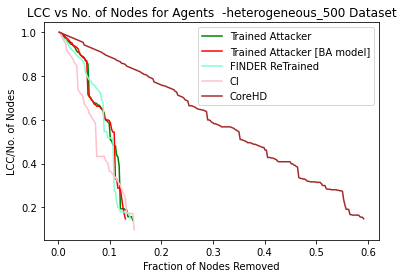

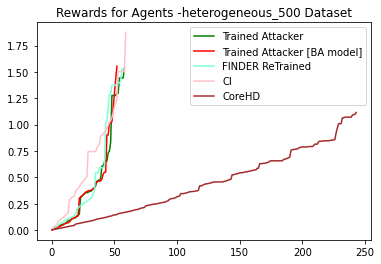

In [3]:
graph_path= "./Dataset/HomogeneityGraph/"
file_list =  ['heterogeneous_30','heterogeneous_50','heterogeneous_100','heterogeneous_500']
AUC = visual_evaluation(graph_path,file_list,[attacker[0],parameter[0]],[attacker[1],parameter[1]])


In [4]:
file = ['differentGraph','BAGraph','FinderReTrained','CI','CoreHD']
print('Test Name','\t\t','Mix','\t','BA','\t','FIN','\t','CI''\t','CoreHD''\t','BEST')
for i, element in enumerate(AUC):
    for nested_tem in element:
        if isinstance(nested_tem, str): 
            print(nested_tem, end=" => \t")
        else:
            print("{:.2f}".format(nested_tem), end=" \t")
    
    best = np.argmin(np.array(element[1:]).astype(float))
    print(file[best])
    print("")
print("===============================")

Test Name 		 Mix 	 BA 	 FIN 	 CI	 CoreHD	 BEST
heterogeneous_30 => 	4.35 	4.09 	3.98 	3.98 	6.96 	FinderReTrained

heterogeneous_50 => 	5.69 	6.53 	5.89 	7.26 	12.32 	differentGraph

heterogeneous_100 => 	8.95 	9.60 	8.66 	8.32 	28.95 	CI

heterogeneous_500 => 	38.52 	37.33 	37.12 	32.93 	147.61 	CI



homogeneous_30
[17, 26, 4, 24, 1, 3, 2, 22, 23, 21, 12, 7]
[17, 26, 3, 1, 24, 2, 4, 22, 23, 21, 7]


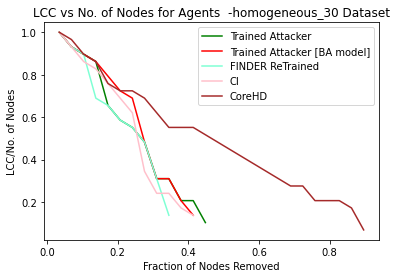

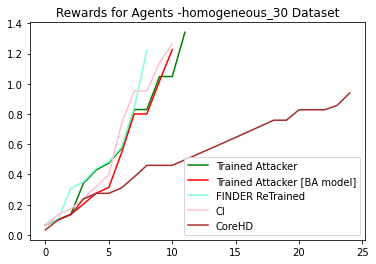

homogeneous_50
[47, 33, 1, 19, 23, 2, 40, 4, 35, 20, 29, 21, 34, 30, 3, 5]
[33, 47, 1, 23, 19, 2, 40, 35, 4, 29, 3, 20, 34, 30, 5]


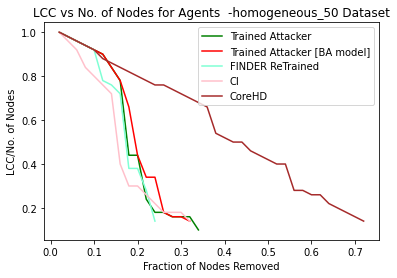

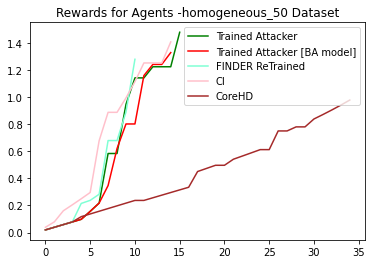

homogeneous_100
[64, 89, 63, 10, 13, 0, 49, 79, 6, 8, 14, 67, 77, 7, 85, 15, 78, 5, 60, 21, 29]
[64, 89, 78, 13, 10, 63, 5, 60, 4, 49, 61, 7, 59, 77, 6, 21, 29, 8, 85, 3, 67]


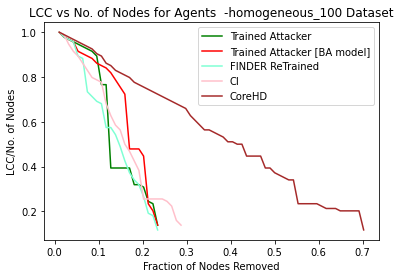

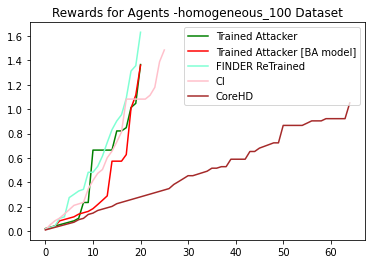

homogeneous_500
[465, 459, 63, 138, 61, 223, 88, 3, 404, 26, 412, 452, 190, 417, 1, 461, 114, 178, 272, 57, 204, 415, 167, 149, 135, 414, 345, 227, 284, 125, 384, 124, 438, 96, 374, 270, 137, 455, 2, 162, 25, 78, 372, 100, 188, 373, 50, 463, 371, 327, 219, 196, 233, 222, 170, 431, 60, 205, 252, 254, 98, 376, 450, 21, 164, 174, 207, 273, 165, 102, 343]
[355, 460, 63, 459, 138, 452, 61, 88, 26, 223, 3, 412, 404, 190, 438, 178, 417, 1, 114, 96, 345, 57, 374, 414, 135, 254, 149, 272, 167, 125, 124, 284, 204, 227, 461, 415, 25, 60, 205, 373, 219, 170, 164, 21, 463, 100, 162, 188, 174, 376, 196, 233, 381, 384, 137, 270, 78, 2, 450, 98, 327, 222, 371, 50, 455, 176, 206, 195, 234, 24, 87, 207, 439, 358, 261, 235, 99, 168, 22, 23, 169, 175, 177, 224]


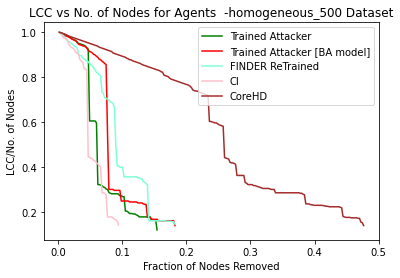

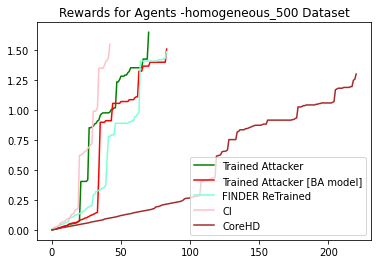

In [11]:
graph_path= "./Dataset/HomogeneityGraph/"
file_list =  ['homogeneous_30','homogeneous_50','homogeneous_100','homogeneous_500']
AUC = visual_evaluation(graph_path,file_list,[attacker[0],parameter[0]],[attacker[1],parameter[1]])

In [12]:
file = ['differentGraph','BAGraph','FinderReTrained','CI','CoreHD']
print('Test Name','\t\t','Mix','\t','BA','\t','FIN','\t','CI''\t','CoreHD''\t','BEST')
for i, element in enumerate(AUC):
    for nested_tem in element:
        if isinstance(nested_tem, str): 
            print(nested_tem, end=" => \t")
        else:
            print("{:.2f}".format(nested_tem), end=" \t")
    
    best = np.argmin(np.array(element[1:]).astype(float))
    print(file[best])
    print("")
print("===============================")

Test Name 		 Mix 	 BA 	 FIN 	 CI	 CoreHD	 BEST
homogeneous_30 => 	6.55 	6.78 	5.67 	6.26 	12.67 	FinderReTrained

homogeneous_50 => 	8.83 	9.17 	7.67 	7.59 	20.39 	CI

homogeneous_100 => 	13.02 	15.03 	12.34 	14.51 	36.62 	FinderReTrained

homogeneous_500 => 	34.47 	43.46 	46.46 	25.71 	128.49 	CI



# Synthetic with Motifs Attached

ba_300_20_house_1
[8, 6, 3, 1, 10, 0, 42, 104, 7, 44, 2, 9, 46, 105, 5, 267, 143, 12, 107, 85, 4, 110, 166, 108, 103, 57, 13, 193, 219, 51, 43, 112, 294, 16, 11, 205, 106, 49, 218, 169, 114, 303, 164, 52, 248, 192, 22, 60, 281, 59, 87, 274, 14, 222, 61, 119, 56, 288, 58, 275, 86, 300, 245, 191, 177, 146, 50, 167, 254, 109, 97, 260, 63, 54, 286, 307, 195, 66, 93, 229, 53, 17, 153, 252, 75, 96, 101, 156, 122, 236, 175, 72, 189, 20, 173, 210, 71, 145, 299, 285, 26, 95, 208, 257, 249, 230, 326, 322]
[8, 6, 3, 10, 1, 7, 104, 42, 0, 44, 9, 2, 46, 105, 5, 267, 103, 143, 107, 85, 166, 108, 57, 12, 13, 193, 294, 4, 51, 205, 219, 112, 43, 106, 11, 119, 110, 16, 248, 218, 49, 114, 52, 303, 169, 164, 60, 281, 22, 61, 56, 130, 192, 87, 14, 222, 245, 86, 191, 177, 275, 95, 300, 288, 274, 153, 252, 59, 58, 307, 50, 146, 97, 63, 47, 254, 167, 230, 93, 136, 260, 156, 195, 297, 122, 96, 66, 210, 109, 236, 175, 26, 173, 54, 208, 72, 323, 17, 145, 324, 20, 325, 315, 75, 249]


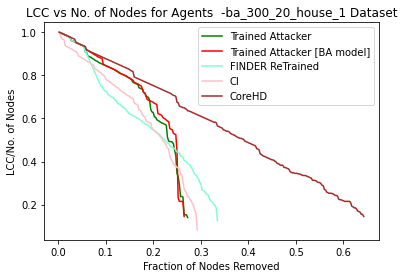

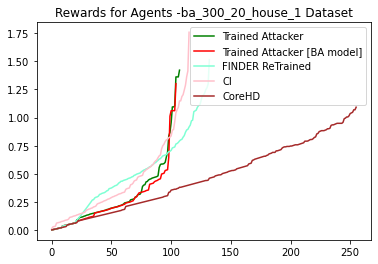

ba_300_40_house_2
[0, 7, 8, 82, 6, 15, 122, 3, 5, 12, 14, 9, 1, 23, 24, 21, 16, 127, 10, 96, 102, 18, 34, 20, 17, 213, 107, 123, 106, 263, 204, 11, 25, 13, 19, 170, 275, 124, 223, 27, 83, 148, 150, 220, 103, 212, 211, 187, 108, 228, 171, 147, 43, 207, 239, 243, 133, 234, 254, 131, 152, 22, 101, 190, 40, 36, 113, 222, 278, 173, 172, 199, 26, 279, 227, 157, 232, 84, 242, 286, 200, 151, 54, 262, 282, 47, 85, 37, 281, 248, 2, 78, 104, 191, 188, 343, 308, 162, 87, 203, 72, 136, 304, 44, 206, 289, 129, 118, 42, 257, 301, 295, 345, 33, 462, 119, 238, 41, 70, 132, 341, 35, 334, 342, 320]
[0, 7, 8, 82, 6, 15, 122, 3, 12, 9, 5, 14, 1, 24, 23, 21, 10, 127, 16, 18, 96, 102, 17, 20, 263, 34, 211, 25, 11, 123, 106, 107, 213, 13, 223, 124, 170, 148, 204, 19, 152, 27, 275, 187, 43, 212, 150, 103, 28, 147, 234, 220, 108, 83, 171, 207, 254, 173, 113, 228, 198, 151, 89, 40, 304, 36, 101, 131, 60, 265, 22, 239, 222, 279, 84, 262, 242, 172, 243, 98, 232, 132, 155, 85, 33, 72, 214, 54, 295, 37, 282, 191, 47

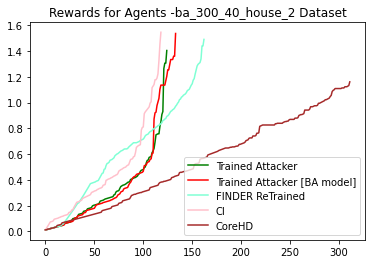

ba_300_60_house_3
[6, 7, 2, 0, 8, 12, 4, 10, 1, 76, 20, 9, 11, 14, 77, 143, 58, 56, 118, 218, 81, 26, 82, 183, 19, 61, 84, 219, 57, 187, 155, 275, 13, 129, 156, 209, 115, 17, 85, 90, 79, 192, 210, 184, 241, 232, 152, 157, 308, 88, 78, 254, 197, 18, 295, 15, 163, 21, 96, 16, 64, 5, 54, 296, 225, 119, 291, 35, 207, 42, 87, 273, 62, 265, 92, 259, 220, 246, 289, 356, 65, 211, 215, 294, 191, 248, 284, 233, 130, 298, 135, 162, 28, 327, 282, 345, 107, 30, 343, 269, 181, 29, 166, 301, 128, 362, 234, 293, 348, 446, 194, 121, 334, 164, 80, 145, 436, 249, 287, 193]
[6, 7, 2, 0, 8, 12, 10, 4, 1, 9, 76, 20, 77, 11, 14, 56, 218, 143, 118, 93, 82, 81, 26, 61, 58, 183, 17, 57, 84, 275, 19, 219, 209, 156, 155, 187, 13, 85, 79, 115, 90, 129, 60, 158, 184, 192, 210, 78, 254, 273, 96, 308, 15, 157, 16, 18, 232, 21, 241, 295, 152, 62, 197, 5, 64, 265, 296, 163, 291, 88, 92, 35, 220, 25, 54, 246, 207, 289, 87, 225, 191, 211, 294, 80, 248, 356, 259, 233, 226, 130, 284, 271, 107, 28, 135, 162, 234, 270, 556, 

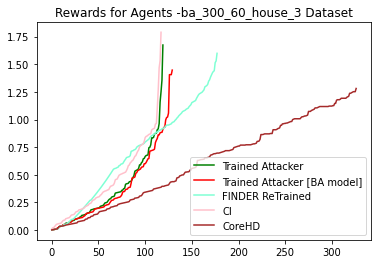

ba_300_80_house_4
[0, 2, 5, 10, 6, 9, 1, 8, 13, 19, 162, 7, 12, 20, 260, 22, 14, 66, 209, 18, 175, 127, 67, 17, 23, 26, 15, 129, 98, 31, 163, 97, 101, 11, 302, 29, 139, 298, 80, 42, 141, 70, 3, 142, 72, 27, 79, 69, 199, 38, 16, 100, 28, 24, 251, 224, 21, 44, 25, 39, 181, 30, 106, 143, 85, 237, 288, 99, 103, 184, 33, 245, 235, 241, 71, 193, 226, 146, 50, 264, 198, 211, 46, 74, 151, 286, 247, 317, 218, 131, 132, 189, 257, 120, 144, 240, 114, 384, 369, 191, 265, 253, 275, 115, 35, 138, 297, 77, 208, 239, 213, 291, 111, 373, 352, 43, 113, 382, 379, 386, 387, 385, 360, 380, 345, 200, 335, 325, 348, 339, 377, 140]
[0, 2, 5, 6, 10, 9, 1, 8, 19, 13, 12, 7, 22, 162, 18, 260, 20, 67, 14, 17, 66, 127, 23, 139, 15, 209, 97, 129, 98, 26, 101, 29, 11, 302, 31, 3, 69, 70, 141, 163, 42, 298, 199, 16, 100, 72, 80, 79, 27, 85, 25, 224, 44, 24, 21, 38, 142, 106, 30, 28, 181, 184, 193, 245, 288, 198, 39, 235, 237, 33, 103, 241, 146, 264, 211, 226, 50, 110, 143, 220, 71, 130, 257, 271, 115, 99, 46, 218, 18

ba_300_100_house_5
[0, 105, 6, 7, 122, 18, 10, 5, 14, 4, 9, 17, 19, 8, 107, 194, 128, 249, 20, 42, 162, 3, 34, 11, 23, 30, 145, 144, 92, 88, 197, 66, 21, 40, 124, 268, 13, 168, 306, 231, 130, 275, 16, 123, 36, 28, 146, 74, 109, 174, 86, 183, 54, 12, 15, 236, 173, 200, 127, 114, 223, 229, 32, 29, 44, 47, 199, 83, 232, 303, 170, 182, 196, 106, 85, 283, 222, 224, 75, 125, 150, 207, 189, 94, 87, 33, 22, 248, 152, 332, 25, 389, 285, 317, 297, 263, 289, 246, 2, 147, 190, 24, 45, 201, 310, 27, 133, 383, 237, 43, 269, 76, 167, 137, 240, 264, 148, 327, 52, 126, 111, 177, 166, 158, 67, 38]
[0, 105, 6, 7, 5, 10, 18, 122, 4, 14, 9, 8, 17, 19, 107, 194, 162, 249, 42, 20, 11, 34, 144, 23, 145, 30, 128, 3, 197, 196, 86, 66, 92, 88, 16, 40, 275, 21, 13, 168, 124, 109, 15, 130, 12, 174, 123, 306, 183, 173, 28, 114, 25, 223, 32, 36, 200, 231, 236, 212, 62, 54, 146, 170, 83, 106, 47, 199, 232, 207, 74, 127, 44, 29, 303, 222, 189, 289, 94, 147, 327, 87, 224, 283, 89, 150, 33, 41, 262, 248, 285, 240, 22, 1

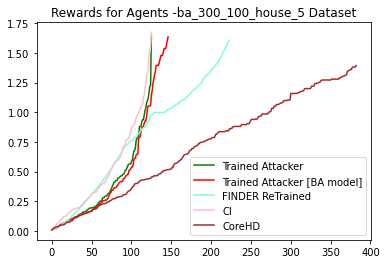

ba_300_20_fan_1
[0, 6, 3, 7, 68, 14, 66, 10, 1, 106, 105, 11, 71, 8, 9, 24, 5, 15, 12, 134, 73, 18, 4, 67, 152, 145, 2, 70, 94, 22, 265, 211, 69, 109, 13, 156, 165, 17, 295, 189, 95, 81, 153, 23, 41, 112, 108, 29, 232, 27, 125, 197, 107, 39, 143, 36, 161, 151, 219, 110, 16, 276, 74, 19, 193, 149, 87, 248, 288, 97, 100, 284, 88, 155, 218, 239, 293, 21, 32, 160, 230, 303, 258, 229, 319, 159, 289, 111, 286, 280, 96, 210, 76, 72, 182, 256, 176, 38, 215, 171, 114, 260, 116, 101, 317, 82, 294, 144, 122, 246, 141, 307, 273, 48, 85, 191, 163, 137, 220, 302, 186]
[0, 6, 3, 7, 66, 68, 14, 1, 8, 106, 10, 105, 11, 9, 71, 134, 15, 5, 24, 12, 4, 67, 73, 2, 152, 145, 18, 70, 94, 22, 69, 265, 211, 156, 13, 112, 109, 95, 17, 189, 165, 23, 153, 27, 295, 41, 135, 108, 29, 218, 39, 125, 197, 107, 161, 143, 232, 230, 110, 276, 16, 32, 219, 74, 19, 193, 149, 87, 288, 313, 100, 171, 36, 160, 256, 239, 97, 293, 21, 159, 303, 229, 81, 155, 319, 258, 111, 38, 289, 266, 182, 210, 72, 213, 144, 96, 176, 116, 284,

ba_300_40_fan_2
[8, 1, 7, 0, 131, 10, 6, 11, 223, 3, 2, 16, 62, 68, 110, 240, 63, 316, 96, 177, 95, 158, 18, 322, 161, 12, 13, 15, 138, 56, 9, 187, 59, 99, 64, 57, 133, 273, 114, 219, 235, 157, 128, 5, 278, 241, 61, 274, 120, 127, 19, 206, 30, 185, 22, 65, 266, 72, 66, 181, 17, 132, 67, 43, 178, 140, 156, 183, 326, 70, 20, 98, 255, 207, 186, 58, 117, 162, 220, 55, 270, 160, 69, 118, 314, 142, 141, 182, 29, 180, 226, 26, 4, 27, 60, 171, 103, 303, 263, 24, 205, 211, 83, 124, 134, 81, 189, 82, 85, 76, 107, 77, 145, 247, 242, 75, 221]
[8, 1, 7, 0, 131, 6, 10, 11, 223, 2, 3, 16, 96, 68, 62, 240, 63, 110, 56, 15, 177, 158, 12, 95, 138, 161, 18, 13, 9, 187, 59, 99, 114, 57, 273, 133, 19, 64, 219, 241, 235, 61, 157, 274, 319, 207, 5, 120, 127, 30, 307, 22, 58, 72, 185, 65, 66, 178, 43, 183, 128, 67, 98, 181, 132, 17, 70, 156, 255, 266, 140, 186, 162, 326, 206, 314, 20, 270, 220, 40, 160, 262, 141, 159, 142, 180, 199, 26, 60, 117, 29, 190, 4, 303, 171, 24, 168, 107, 211, 263, 97, 50, 71, 124, 1

ba_300_60_fan_3
[0, 6, 9, 185, 10, 140, 86, 13, 7, 14, 12, 11, 68, 8, 69, 15, 98, 109, 85, 188, 2, 71, 111, 57, 156, 211, 17, 3, 1, 87, 90, 5, 23, 27, 143, 187, 281, 21, 89, 29, 25, 203, 70, 304, 36, 31, 201, 196, 119, 32, 327, 319, 112, 186, 126, 18, 110, 127, 26, 147, 193, 141, 60, 283, 94, 291, 262, 28, 124, 88, 348, 77, 74, 43, 157, 33, 40, 314, 238, 243, 55, 20, 30, 275, 247, 221, 179, 230, 282, 241, 251, 76, 205, 35, 274, 176, 130, 114, 180, 202, 135, 248, 220, 250, 195, 310, 214, 246, 133, 173, 101, 161, 240, 227, 218, 293, 198, 146, 103, 19, 264]
[0, 6, 10, 185, 9, 140, 86, 7, 12, 13, 68, 14, 11, 8, 69, 109, 85, 98, 71, 15, 188, 111, 2, 57, 3, 211, 87, 156, 17, 1, 143, 27, 90, 23, 187, 21, 5, 304, 89, 191, 29, 203, 36, 70, 18, 31, 201, 272, 32, 193, 196, 281, 74, 110, 25, 186, 126, 77, 141, 112, 60, 283, 127, 94, 88, 124, 119, 262, 291, 26, 28, 147, 157, 33, 243, 330, 40, 314, 238, 214, 115, 275, 282, 202, 20, 76, 230, 241, 274, 176, 205, 35, 251, 130, 135, 247, 173, 179, 114, 

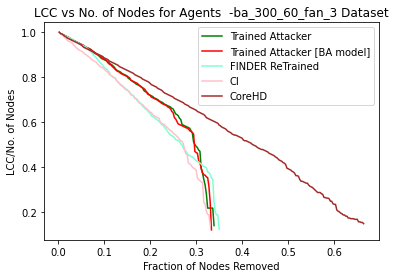

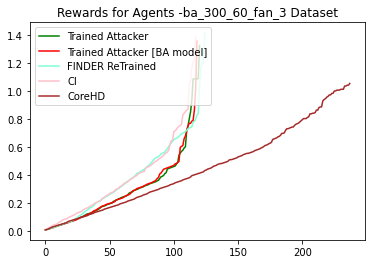

ba_300_80_fan_4
[6, 9, 0, 7, 8, 2, 12, 5, 28, 14, 3, 10, 1, 86, 4, 87, 17, 19, 89, 23, 68, 88, 131, 67, 15, 191, 91, 130, 26, 16, 265, 217, 30, 11, 243, 92, 165, 74, 147, 220, 36, 22, 207, 161, 95, 110, 98, 162, 20, 193, 70, 308, 246, 112, 25, 32, 43, 234, 157, 290, 53, 303, 213, 368, 116, 150, 133, 264, 29, 170, 171, 319, 118, 39, 169, 42, 120, 33, 49, 35, 40, 173, 137, 172, 218, 31, 208, 69, 46, 250, 280, 136, 198, 270, 144, 212, 377, 206, 194, 138, 119, 111, 332, 101, 99, 365, 57, 296, 174, 100, 38, 185, 235, 164, 301, 259, 134, 228, 276, 326, 309, 85, 286, 13, 163, 209]
[6, 0, 9, 7, 8, 2, 5, 12, 28, 3, 10, 14, 1, 4, 86, 87, 19, 17, 68, 89, 23, 15, 131, 67, 191, 88, 217, 91, 243, 130, 165, 265, 161, 26, 92, 11, 220, 36, 147, 25, 30, 16, 74, 207, 95, 110, 22, 98, 118, 193, 20, 70, 112, 246, 162, 290, 303, 145, 157, 53, 32, 355, 213, 144, 116, 49, 316, 133, 170, 43, 200, 319, 29, 31, 39, 124, 171, 308, 120, 33, 226, 137, 173, 101, 35, 40, 172, 119, 218, 234, 46, 286, 152, 270, 208, 34

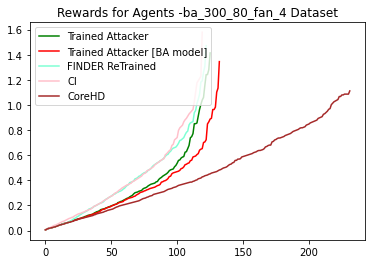

ba_300_100_fan_5
[8, 0, 6, 10, 9, 12, 7, 11, 53, 13, 151, 75, 93, 125, 74, 72, 55, 18, 2, 1, 126, 16, 14, 94, 95, 79, 5, 59, 76, 17, 219, 26, 204, 245, 174, 3, 158, 236, 203, 116, 131, 23, 71, 201, 25, 202, 179, 152, 207, 206, 154, 260, 371, 314, 34, 225, 157, 155, 15, 247, 296, 32, 135, 221, 290, 272, 130, 127, 28, 77, 31, 255, 137, 312, 177, 178, 129, 249, 295, 266, 63, 4, 102, 275, 189, 238, 176, 282, 317, 319, 121, 172, 128, 54, 232, 246, 224, 141, 82, 36, 21, 118, 101, 91, 84, 37, 58, 262, 29, 145, 22, 398, 305, 39, 297]
[0, 8, 6, 10, 9, 7, 12, 11, 53, 151, 13, 75, 72, 93, 55, 74, 125, 18, 2, 16, 14, 94, 1, 126, 76, 17, 95, 5, 79, 59, 219, 245, 3, 26, 158, 204, 174, 236, 113, 203, 116, 97, 202, 71, 32, 34, 23, 325, 300, 201, 154, 25, 207, 206, 179, 157, 152, 314, 221, 15, 19, 127, 225, 28, 290, 135, 131, 247, 275, 342, 137, 176, 99, 276, 4, 20, 189, 255, 129, 266, 178, 54, 249, 389, 155, 224, 232, 369, 363, 320, 21, 115, 291, 322, 144, 177, 172, 331, 30, 82, 312, 230, 319, 295, 39

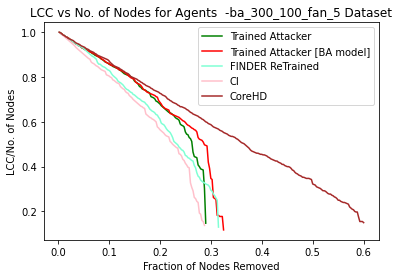

ba_300_20_clique_1
[7, 0, 10, 13, 12, 6, 3, 18, 4, 9, 2, 14, 106, 131, 11, 110, 15, 22, 107, 81, 230, 67, 66, 16, 82, 89, 199, 1, 45, 44, 108, 172, 170, 5, 222, 37, 112, 171, 159, 158, 84, 29, 200, 233, 26, 83, 139, 211, 114, 179, 265, 176, 25, 224, 90, 147, 35, 95, 8, 97, 71, 86, 245, 138, 119, 281, 174, 261, 120, 122, 93, 157, 59, 111, 258, 20, 55, 212, 115, 24, 178, 232, 214, 228, 36, 34, 244, 69, 225, 270, 285, 300, 289, 17, 92, 56, 239, 80, 19, 42, 269, 23, 168, 113, 201, 183, 247]
[7, 0, 10, 12, 6, 3, 13, 18, 4, 9, 2, 50, 11, 106, 14, 131, 15, 110, 81, 230, 107, 22, 67, 16, 66, 82, 89, 199, 45, 1, 172, 44, 108, 5, 170, 222, 37, 112, 29, 159, 158, 171, 84, 200, 233, 83, 211, 139, 26, 114, 179, 265, 25, 176, 147, 194, 122, 35, 261, 95, 284, 71, 90, 245, 174, 86, 56, 119, 120, 74, 8, 132, 36, 166, 157, 258, 59, 224, 115, 232, 178, 149, 93, 215, 236, 270, 212, 97, 49, 20, 92, 168, 280, 17, 184, 219, 23, 24, 269, 204, 297, 300, 137, 292, 111, 141]


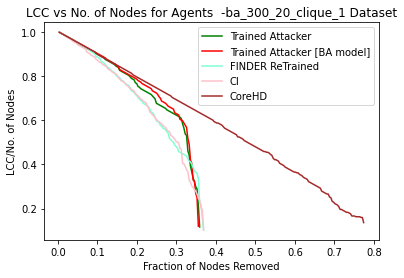

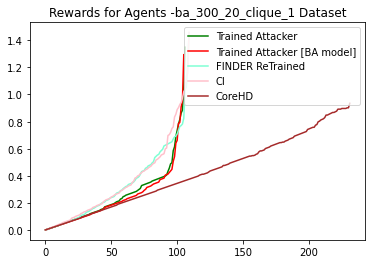

ba_300_40_clique_2
[6, 7, 51, 0, 52, 50, 11, 9, 2, 137, 1, 14, 53, 4, 141, 114, 12, 3, 15, 78, 17, 55, 161, 10, 8, 226, 133, 102, 142, 16, 57, 140, 18, 25, 233, 240, 246, 160, 116, 81, 274, 192, 58, 188, 22, 235, 56, 134, 186, 115, 84, 147, 100, 184, 293, 162, 152, 61, 135, 232, 108, 28, 264, 213, 164, 159, 167, 90, 139, 13, 88, 190, 110, 228, 236, 229, 144, 138, 278, 103, 59, 34, 204, 36, 111, 38, 298, 183, 77, 170, 193, 275, 243, 291, 117, 44, 227, 163, 207, 252, 297, 85, 285, 250, 31, 29, 271, 187, 37, 281, 245, 156, 23, 158, 238, 212, 21, 267, 5, 120, 283, 125, 91]
[6, 7, 51, 0, 52, 11, 50, 9, 2, 137, 1, 14, 53, 4, 141, 3, 12, 114, 15, 55, 10, 78, 17, 161, 8, 133, 226, 102, 233, 57, 18, 16, 140, 142, 25, 240, 116, 246, 274, 81, 160, 192, 188, 235, 58, 56, 22, 101, 186, 293, 84, 100, 147, 61, 232, 184, 23, 135, 159, 152, 190, 108, 28, 213, 164, 90, 115, 36, 162, 54, 13, 88, 243, 228, 110, 170, 103, 118, 59, 34, 278, 134, 236, 251, 265, 111, 77, 167, 144, 158, 156, 271, 275, 204, 298

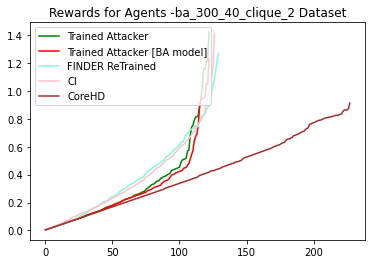

ba_300_60_clique_3
[8, 10, 53, 12, 100, 0, 6, 4, 13, 9, 76, 7, 194, 1, 11, 282, 54, 196, 264, 18, 166, 56, 3, 126, 135, 24, 19, 16, 105, 5, 274, 226, 155, 243, 2, 14, 232, 195, 140, 266, 101, 17, 200, 167, 79, 209, 267, 20, 55, 265, 37, 275, 93, 184, 85, 137, 170, 157, 180, 21, 108, 15, 284, 61, 169, 219, 220, 136, 125, 31, 162, 294, 80, 95, 242, 26, 177, 91, 260, 281, 163, 202, 199, 111, 293, 112, 212, 110, 146, 63, 198, 268, 154, 59, 75, 300, 159, 82, 158, 296, 114, 249, 205, 77, 69, 62, 89, 283]
[8, 10, 53, 100, 0, 12, 6, 4, 13, 9, 76, 7, 194, 1, 24, 54, 282, 18, 11, 166, 196, 56, 264, 3, 126, 16, 19, 135, 105, 243, 2, 266, 274, 21, 155, 5, 14, 195, 226, 101, 140, 167, 17, 79, 267, 200, 209, 55, 20, 93, 85, 184, 137, 242, 157, 275, 37, 180, 15, 61, 220, 219, 108, 170, 136, 31, 169, 162, 294, 125, 284, 95, 80, 202, 91, 26, 260, 177, 163, 179, 281, 293, 112, 212, 154, 63, 198, 146, 110, 199, 257, 59, 159, 82, 75, 62, 205, 114, 69, 206, 158, 249, 111, 283, 84, 276, 261, 41, 122]


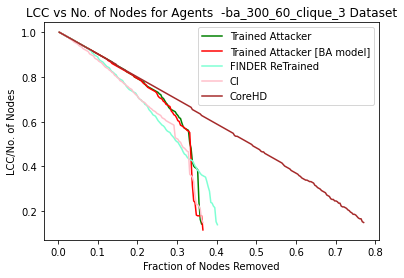

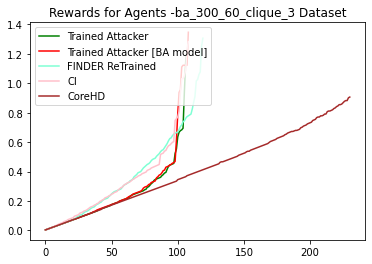

ba_300_80_clique_4
[60, 0, 2, 9, 7, 74, 6, 10, 76, 75, 8, 4, 115, 61, 254, 142, 126, 11, 16, 3, 128, 20, 1, 18, 252, 17, 5, 80, 203, 164, 79, 19, 26, 152, 166, 216, 81, 82, 13, 195, 118, 165, 129, 247, 127, 78, 204, 158, 30, 92, 83, 228, 89, 143, 160, 159, 236, 119, 155, 185, 27, 299, 251, 12, 25, 250, 284, 289, 23, 241, 35, 276, 32, 88, 24, 287, 15, 178, 208, 167, 199, 42, 196, 174, 235, 291, 21, 275, 22, 168, 36, 95, 90, 98, 266, 295, 31, 101, 242, 14, 270, 157, 105, 269, 77, 123, 104, 286, 262, 192, 28, 179, 298, 274, 47, 277, 280]
[60, 0, 2, 9, 7, 74, 6, 10, 76, 8, 75, 115, 61, 4, 254, 142, 126, 16, 11, 3, 128, 20, 1, 18, 185, 17, 5, 26, 80, 252, 166, 19, 79, 164, 203, 82, 152, 13, 195, 216, 204, 118, 129, 81, 158, 127, 165, 247, 78, 30, 92, 228, 143, 83, 160, 89, 299, 159, 236, 27, 119, 251, 250, 155, 284, 25, 276, 289, 23, 12, 287, 35, 24, 241, 88, 15, 184, 32, 208, 167, 199, 14, 174, 46, 275, 237, 235, 168, 21, 36, 291, 42, 285, 38, 266, 295, 22, 270, 31, 242, 157, 95, 90, 123, 

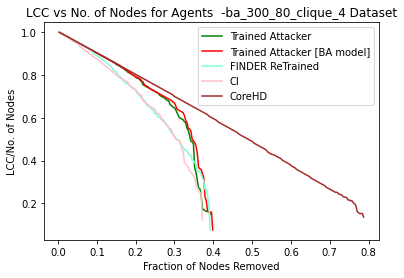

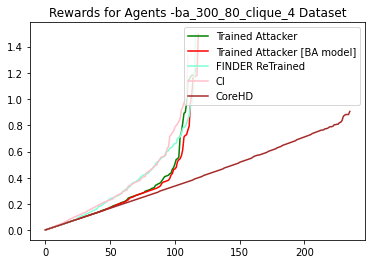

ba_300_100_clique_5
[81, 0, 6, 8, 4, 119, 7, 10, 12, 2, 84, 18, 9, 154, 120, 20, 25, 16, 19, 17, 85, 14, 3, 185, 148, 15, 33, 156, 161, 107, 86, 13, 11, 122, 194, 163, 123, 28, 32, 109, 35, 90, 126, 92, 162, 159, 186, 167, 193, 29, 51, 150, 247, 61, 111, 240, 24, 227, 118, 42, 190, 128, 48, 229, 27, 182, 149, 26, 254, 291, 174, 157, 52, 105, 183, 235, 228, 134, 259, 82, 155, 151, 264, 125, 21, 277, 34, 198, 30, 37, 83, 294, 202, 253, 47, 121, 89, 299, 98, 293, 77, 237, 215, 41, 36, 262, 165, 184, 73, 231, 209, 271, 230, 131, 5, 272, 234, 55, 144]
[81, 0, 6, 8, 119, 7, 4, 10, 12, 2, 84, 154, 18, 9, 120, 25, 20, 16, 19, 85, 17, 14, 3, 15, 156, 185, 33, 107, 161, 148, 86, 11, 13, 163, 122, 194, 28, 32, 123, 109, 35, 92, 223, 126, 162, 90, 159, 29, 167, 193, 247, 240, 61, 111, 227, 150, 24, 44, 51, 118, 190, 42, 186, 275, 27, 48, 254, 182, 149, 291, 183, 36, 184, 294, 105, 157, 82, 155, 165, 284, 281, 216, 259, 229, 151, 125, 63, 202, 297, 21, 121, 89, 215, 98, 37, 209, 106, 237, 264, 280,

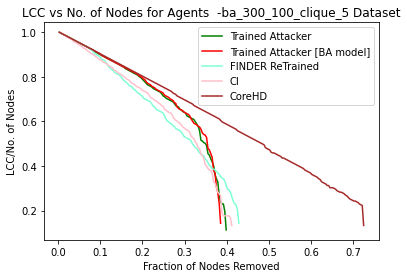

ba_300_20_diamond_1
[6, 2, 47, 0, 5, 100, 64, 8, 9, 7, 48, 11, 109, 188, 70, 138, 134, 73, 135, 67, 13, 17, 77, 1, 65, 119, 50, 66, 49, 69, 22, 27, 21, 168, 19, 139, 169, 98, 196, 101, 108, 14, 78, 26, 16, 137, 207, 163, 12, 167, 234, 295, 267, 15, 265, 111, 148, 136, 229, 28, 61, 84, 112, 33, 198, 210, 114, 23, 273, 144, 52, 74, 117, 192, 248, 319, 99, 307, 4, 54, 298, 152, 193, 268, 179, 24, 88, 274, 227, 279, 194, 63, 81, 314, 191, 318, 322, 310, 85, 321, 323, 320, 308, 325, 251, 76, 297, 316, 317, 270, 240, 171, 82, 205, 258, 250, 51, 376, 46, 238, 283, 299, 301, 302, 304, 326, 221, 92, 142, 327, 10, 271, 201, 293, 143, 68, 202, 102, 103, 222, 278]
[6, 2, 47, 0, 5, 100, 8, 9, 7, 64, 48, 109, 11, 70, 134, 188, 138, 135, 73, 1, 66, 17, 69, 13, 50, 77, 119, 67, 49, 65, 27, 21, 22, 168, 19, 169, 196, 98, 139, 101, 234, 14, 78, 167, 137, 26, 295, 16, 112, 207, 15, 12, 108, 265, 111, 118, 88, 4, 84, 144, 273, 148, 52, 229, 61, 267, 192, 23, 114, 54, 210, 51, 319, 117, 74, 94, 24, 170, 85

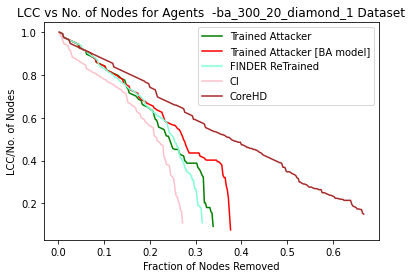

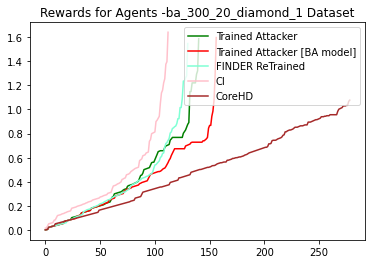

ba_300_40_diamond_2
[0, 6, 13, 1, 101, 12, 11, 2, 10, 4, 9, 102, 75, 78, 7, 80, 128, 76, 31, 8, 149, 249, 28, 175, 17, 32, 15, 20, 23, 148, 27, 193, 268, 412, 130, 122, 5, 107, 156, 18, 77, 129, 79, 250, 212, 29, 253, 151, 123, 109, 54, 38, 177, 126, 229, 162, 103, 37, 263, 124, 21, 176, 25, 209, 267, 81, 22, 191, 254, 53, 307, 88, 87, 86, 190, 118, 324, 218, 150, 55, 24, 309, 134, 171, 178, 207, 111, 232, 3, 202, 104, 325, 323, 328, 332, 455, 326, 36, 346, 340, 343, 329, 312, 336, 318, 330, 342, 313, 331, 280, 143, 152, 291, 338, 305, 279, 484, 337, 525, 347, 240, 217, 167, 238, 227, 282, 264, 74, 182, 237, 211, 132, 248, 266, 288, 296, 300, 303, 308, 316, 317, 319, 320, 341, 345, 90, 198, 40, 260, 311, 271, 14, 210]
[0, 6, 101, 13, 1, 12, 2, 11, 4, 10, 7, 9, 8, 78, 75, 128, 102, 80, 28, 149, 249, 31, 76, 175, 15, 17, 23, 32, 18, 20, 193, 27, 156, 122, 268, 148, 77, 107, 5, 250, 79, 129, 151, 212, 103, 123, 109, 130, 54, 253, 162, 126, 229, 37, 38, 176, 177, 263, 21, 29, 152, 124, 209

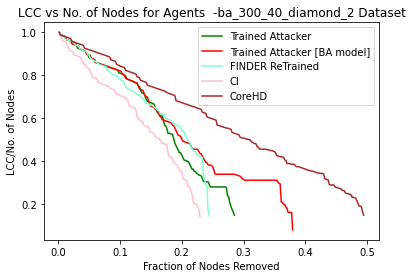

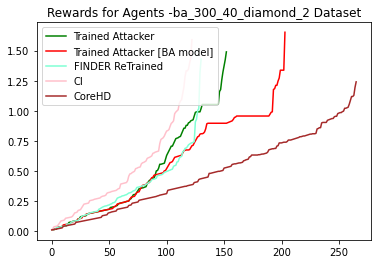

ba_300_60_diamond_3
[0, 7, 2, 8, 6, 156, 69, 68, 10, 67, 5, 1, 9, 72, 14, 70, 15, 127, 142, 158, 159, 17, 12, 13, 39, 26, 97, 247, 139, 128, 20, 33, 206, 275, 30, 224, 130, 71, 138, 19, 189, 100, 129, 106, 11, 98, 74, 239, 164, 105, 262, 27, 76, 29, 82, 44, 184, 40, 91, 250, 289, 303, 165, 25, 73, 166, 171, 37, 16, 231, 103, 110, 222, 215, 93, 41, 335, 94, 259, 4, 355, 144, 58, 351, 367, 191, 359, 207, 157, 241, 268, 288, 354, 280, 205, 293, 99, 236, 186, 153, 132, 272, 233, 336, 317, 341, 344, 360, 338, 345, 292, 28, 286, 109, 187, 174, 432, 339, 364, 314, 328, 340, 337, 346, 329, 334, 343, 332, 366, 277, 356, 433, 316, 333, 486, 598, 621, 350, 640, 31, 102, 217, 391, 104]
[0, 7, 2, 8, 6, 156, 5, 67, 10, 69, 68, 1, 9, 72, 127, 70, 15, 14, 142, 158, 12, 17, 13, 159, 139, 247, 26, 39, 97, 33, 100, 189, 130, 20, 30, 275, 71, 128, 138, 224, 19, 11, 91, 262, 129, 98, 164, 76, 239, 27, 206, 74, 82, 105, 16, 29, 44, 106, 303, 110, 40, 166, 250, 184, 165, 73, 103, 248, 25, 280, 37, 93, 171, 2

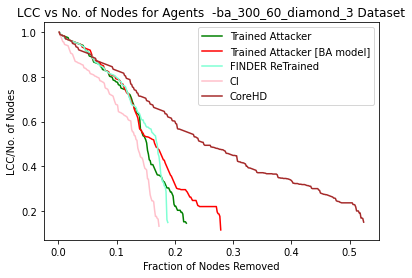

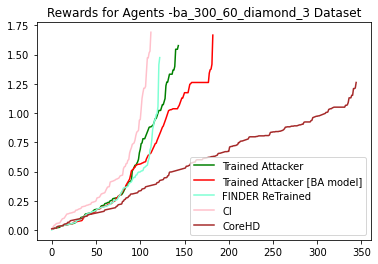

ba_300_80_diamond_4
[6, 0, 7, 4, 86, 8, 76, 5, 15, 12, 203, 10, 121, 87, 11, 225, 138, 9, 90, 13, 192, 117, 24, 230, 17, 119, 118, 140, 23, 75, 77, 29, 25, 20, 141, 124, 216, 59, 81, 41, 139, 61, 181, 78, 206, 33, 99, 2, 35, 269, 97, 150, 85, 80, 240, 263, 229, 94, 1, 100, 294, 111, 158, 127, 281, 120, 74, 279, 132, 377, 359, 16, 14, 47, 95, 672, 45, 194, 88, 379, 83, 104, 161, 204, 175, 239, 291, 91, 207, 215, 288, 156, 330, 290, 107, 178, 592, 144, 21, 264, 40, 283, 386, 675, 391, 564, 711, 384, 342, 355, 332, 147, 325, 329, 84, 361, 380, 712, 340, 385, 387, 376, 193, 334, 338, 38, 363, 331, 318, 328, 381, 373, 320, 389, 364, 390, 687, 666, 311, 469, 635, 162, 760, 317, 341, 39, 22, 145, 223, 297, 662, 692, 756, 738, 316, 58, 172, 213, 228, 243, 110, 101, 262, 274, 278, 287, 293, 299, 301, 306, 310, 314, 319, 322, 323, 324, 327, 335, 336, 337, 345, 348, 350, 351, 352, 353, 356, 357, 358, 366, 369, 374, 375, 383, 343, 362, 247, 65, 382, 292, 19, 268, 179]
[6, 0, 7, 4, 8, 86, 76, 5, 15

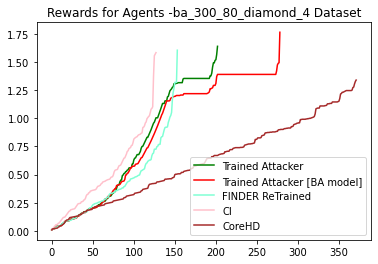

ba_300_100_diamond_5
[0, 6, 63, 9, 187, 13, 1, 144, 64, 96, 11, 2, 3, 16, 10, 4, 8, 223, 72, 7, 17, 15, 69, 19, 5, 252, 153, 238, 119, 152, 117, 66, 253, 97, 148, 309, 12, 14, 162, 178, 73, 240, 22, 204, 228, 120, 132, 74, 254, 154, 78, 23, 255, 217, 28, 274, 209, 118, 68, 98, 156, 43, 200, 30, 276, 121, 18, 197, 155, 199, 218, 41, 273, 247, 85, 379, 355, 201, 319, 358, 183, 79, 37, 135, 83, 883, 107, 205, 320, 402, 399, 788, 300, 341, 167, 86, 239, 373, 188, 395, 363, 837, 357, 327, 334, 362, 349, 31, 400, 353, 406, 348, 347, 381, 184, 388, 169, 146, 397, 390, 407, 386, 389, 382, 516, 67, 266, 329, 394, 344, 331, 375, 396, 81, 376, 182, 368, 387, 335, 378, 325, 342, 352, 393, 306, 367, 385, 391, 836, 36, 350, 316, 615, 729, 782, 787, 868, 314, 366, 668, 351, 354, 377, 324, 259, 268, 460, 404, 401, 87, 372, 886, 109, 493, 369, 312, 51, 88, 611, 725, 778, 783, 864, 130, 177, 216, 237, 283, 290, 297, 298, 302, 303, 308, 311, 315, 317, 322, 323, 326, 330, 332, 333, 336, 338, 340, 345, 356

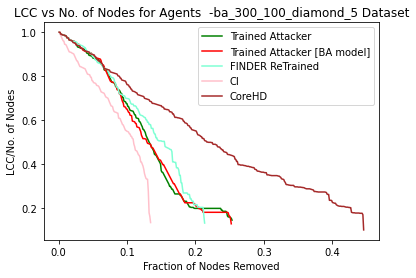

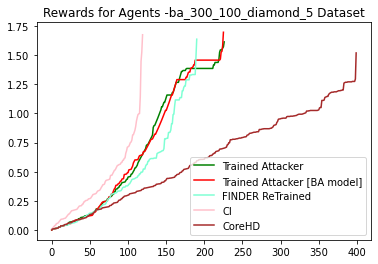

ba_300_20_cycle_1
[43, 3, 143, 2, 111, 0, 6, 44, 7, 1, 10, 9, 46, 75, 8, 50, 4, 48, 212, 180, 116, 242, 15, 45, 11, 12, 115, 145, 47, 52, 184, 122, 78, 118, 182, 283, 14, 110, 203, 17, 179, 146, 114, 53, 163, 295, 79, 254, 34, 221, 76, 49, 144, 112, 230, 234, 243, 181, 55, 54, 217, 187, 132, 84, 94, 80, 85, 92, 235, 274, 59, 171, 57, 159, 31, 51, 88, 157, 28, 60, 201, 22, 208, 95, 67, 256, 20, 279, 169, 83, 275, 135, 93, 58, 124, 131, 89, 304, 63, 119, 222, 209, 292, 102, 154, 251, 81, 66, 232, 16, 177, 240, 263, 219, 178, 241, 267, 161, 162]
[43, 3, 2, 143, 111, 0, 44, 6, 7, 1, 10, 9, 75, 46, 8, 50, 4, 48, 180, 212, 116, 242, 15, 45, 12, 47, 11, 115, 145, 14, 283, 99, 52, 203, 182, 78, 118, 110, 53, 184, 179, 146, 114, 122, 295, 79, 254, 163, 34, 76, 144, 201, 17, 49, 230, 274, 234, 181, 55, 80, 85, 92, 187, 112, 243, 84, 266, 221, 94, 235, 208, 171, 54, 152, 31, 57, 159, 217, 51, 60, 59, 157, 28, 137, 88, 22, 20, 58, 93, 67, 169, 154, 135, 95, 119, 214, 275, 260, 161, 124, 148, 102, 

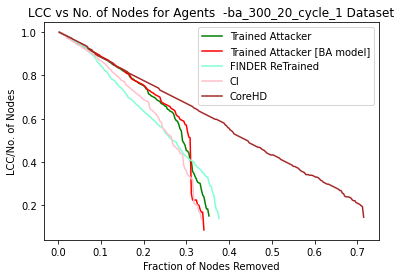

ba_300_40_cycle_2
[6, 0, 8, 7, 2, 10, 9, 109, 180, 3, 12, 56, 55, 4, 94, 219, 14, 16, 13, 196, 91, 11, 54, 244, 112, 164, 93, 90, 59, 95, 114, 113, 142, 111, 15, 189, 27, 18, 230, 129, 22, 60, 110, 70, 186, 25, 181, 98, 137, 63, 145, 21, 166, 206, 132, 120, 33, 168, 263, 97, 165, 62, 146, 68, 292, 268, 61, 247, 269, 231, 64, 140, 92, 220, 278, 205, 5, 99, 342, 39, 265, 77, 254, 259, 209, 136, 221, 257, 66, 279, 75, 169, 197, 249, 47, 302, 82, 171, 29, 252, 250, 299, 72, 119, 324, 289, 152, 122, 139, 143, 19, 213, 238]
[6, 0, 8, 9, 7, 2, 10, 180, 109, 56, 3, 55, 12, 4, 219, 14, 94, 16, 91, 13, 196, 11, 244, 112, 164, 54, 90, 93, 142, 59, 95, 114, 113, 166, 186, 129, 111, 189, 60, 230, 62, 27, 70, 110, 22, 25, 15, 98, 181, 145, 63, 21, 132, 206, 33, 18, 120, 137, 247, 168, 263, 97, 68, 165, 292, 146, 268, 61, 169, 220, 5, 92, 75, 278, 205, 46, 64, 160, 265, 77, 252, 210, 221, 231, 122, 259, 136, 66, 209, 249, 279, 254, 140, 197, 99, 152, 82, 302, 257, 171, 29, 222, 155, 72, 39, 299, 324,

ba_300_60_cycle_3
[0, 9, 10, 2, 11, 7, 77, 6, 12, 78, 161, 138, 67, 13, 118, 17, 3, 160, 114, 84, 223, 26, 113, 81, 140, 8, 162, 71, 139, 217, 25, 1, 79, 134, 183, 185, 115, 117, 15, 88, 268, 243, 16, 254, 85, 277, 184, 186, 116, 164, 166, 34, 40, 50, 281, 232, 82, 4, 247, 24, 83, 191, 103, 309, 269, 14, 192, 70, 31, 238, 270, 287, 128, 195, 135, 230, 20, 204, 91, 174, 307, 313, 38, 231, 252, 329, 146, 127, 320, 105, 97, 69, 120, 100, 291, 271, 90, 216, 189, 290, 144, 148, 169, 256, 35, 27, 239, 59, 87, 44, 260, 150]
[0, 9, 10, 2, 11, 7, 77, 6, 161, 12, 78, 67, 138, 13, 3, 17, 118, 114, 160, 84, 223, 26, 113, 8, 81, 140, 139, 1, 162, 79, 217, 25, 183, 71, 117, 115, 134, 185, 88, 14, 277, 268, 85, 254, 34, 243, 200, 170, 116, 184, 164, 281, 4, 232, 186, 50, 103, 31, 24, 82, 238, 70, 166, 247, 192, 309, 128, 269, 20, 83, 149, 97, 135, 38, 68, 195, 153, 191, 230, 16, 40, 91, 239, 143, 98, 207, 291, 146, 15, 320, 290, 307, 19, 256, 225, 120, 181, 27, 171, 127, 282, 144, 35, 252, 231, 59, 2

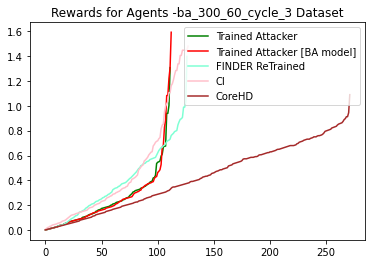

ba_300_80_cycle_4
[0, 8, 2, 76, 18, 9, 15, 14, 7, 26, 6, 21, 10, 4, 5, 13, 80, 130, 38, 37, 169, 235, 144, 11, 261, 79, 33, 23, 31, 77, 3, 19, 12, 22, 30, 157, 155, 78, 296, 241, 84, 29, 86, 34, 135, 90, 39, 242, 275, 214, 32, 28, 236, 110, 178, 234, 123, 280, 120, 16, 40, 215, 172, 221, 216, 247, 35, 20, 25, 36, 170, 209, 87, 83, 266, 91, 156, 305, 163, 145, 126, 314, 281, 49, 180, 74, 138, 121, 115, 185, 118, 200, 263, 230, 294, 73, 111, 24, 99, 27, 211, 60, 278, 17, 94, 229, 186, 53, 319, 291, 93, 44, 164, 45, 173, 55]
[0, 8, 2, 76, 18, 9, 15, 7, 14, 4, 10, 21, 13, 5, 26, 80, 130, 6, 37, 38, 11, 12, 235, 169, 19, 33, 144, 23, 30, 241, 31, 77, 78, 3, 157, 86, 34, 22, 79, 261, 296, 84, 135, 90, 29, 155, 39, 242, 275, 214, 32, 28, 236, 280, 110, 234, 178, 123, 215, 120, 172, 40, 221, 216, 20, 35, 36, 247, 170, 173, 83, 16, 209, 87, 200, 266, 91, 163, 314, 294, 126, 145, 74, 138, 25, 281, 185, 233, 93, 49, 115, 263, 24, 73, 180, 44, 111, 305, 94, 224, 211, 278, 148, 27, 127, 335, 319, 1

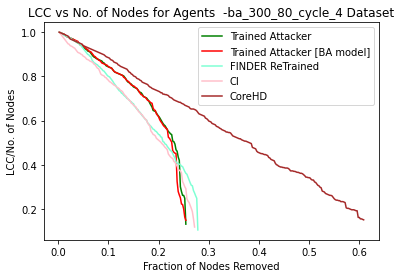

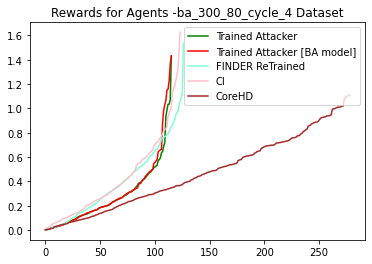

ba_300_100_cycle_5
[8, 6, 0, 7, 13, 2, 170, 117, 17, 9, 10, 11, 143, 103, 28, 4, 219, 3, 12, 139, 34, 141, 171, 261, 30, 21, 53, 169, 76, 230, 194, 140, 16, 19, 198, 14, 36, 5, 86, 199, 241, 104, 234, 80, 27, 29, 26, 266, 77, 193, 20, 24, 302, 174, 25, 122, 1, 48, 144, 18, 233, 41, 271, 120, 329, 243, 82, 121, 209, 57, 85, 231, 321, 69, 32, 22, 149, 107, 160, 79, 15, 188, 189, 232, 245, 132, 153, 35, 37, 129, 125, 244, 162, 50, 183, 225, 325, 286, 275, 105, 254, 106, 311, 179, 195, 84, 269, 294, 301, 152, 43, 281, 39, 317, 173, 56, 310, 109, 289, 282, 119, 67, 52, 204, 433, 124, 249]
[8, 0, 6, 7, 13, 2, 117, 10, 170, 17, 9, 11, 103, 219, 4, 143, 28, 12, 3, 139, 34, 171, 261, 141, 30, 21, 169, 76, 140, 19, 53, 194, 14, 36, 198, 16, 77, 104, 199, 5, 20, 230, 26, 234, 27, 266, 80, 241, 29, 193, 174, 24, 86, 25, 122, 1, 302, 120, 48, 233, 155, 290, 22, 15, 300, 329, 82, 209, 144, 121, 18, 79, 232, 188, 245, 153, 321, 32, 132, 106, 189, 85, 231, 243, 271, 142, 84, 50, 149, 269, 201, 286, 16

/tmp/ipykernel_181711/2786241961.py:61: UserWarning: loadtxt: Empty input file: "./FINDER/FINDER_ReTrained/ba_300_100_cycle_5.txt"
  action_list = np.loadtxt(fname, dtype=int)


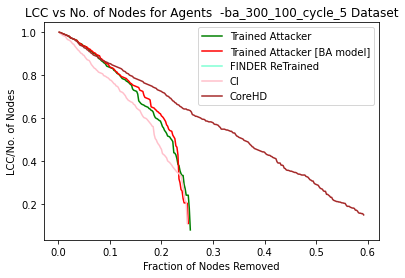

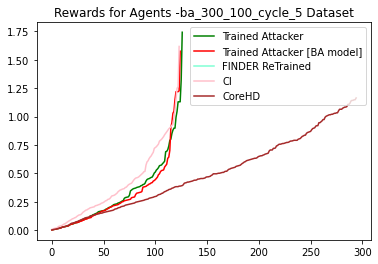

ValueError: At least 2 points are needed to compute area under curve, but x.shape = 1

In [7]:
file_list = ['ba_300_20_house_1', 'ba_300_40_house_2', 'ba_300_60_house_3', 'ba_300_80_house_4', 'ba_300_100_house_5', 'ba_300_20_fan_1', 'ba_300_40_fan_2', 'ba_300_60_fan_3', 'ba_300_80_fan_4', 'ba_300_100_fan_5', 'ba_300_20_clique_1', 'ba_300_40_clique_2', 'ba_300_60_clique_3', 'ba_300_80_clique_4', 'ba_300_100_clique_5', 'ba_300_20_diamond_1', 'ba_300_40_diamond_2', 'ba_300_60_diamond_3', 'ba_300_80_diamond_4', 'ba_300_100_diamond_5', 'ba_300_20_cycle_1', 'ba_300_40_cycle_2', 'ba_300_60_cycle_3', 'ba_300_80_cycle_4', 'ba_300_100_cycle_5', 'ba_300_20_star_1', 'ba_300_40_star_2', 'ba_300_60_star_3', 'ba_300_80_star_4', 'ba_300_100_star_5', 'ba_300_20_grid_1', 'ba_300_40_grid_2', 'ba_300_60_grid_3', 'ba_300_80_grid_4', 'ba_300_100_grid_5']
graph_path = "./Dataset/Validation/Motifs_Attached/BA/"
AUC = visual_evaluation(graph_path,file_list,[attacker[0],parameter[0]],[attacker[1],parameter[1]])


In [10]:
file = ['differentGraph','BAGraph','FinderReTrained','CI','CoreHD']
print('Test Name','\t\t','Mix','\t','BA','\t','FIN','\t','CI''\t','CoreHD''\t','BEST')
for i, element in enumerate(AUC):
    for nested_tem in element:
        if isinstance(nested_tem, str): 
            print(nested_tem, end=" => \t")
        else:
            print("{:.2f}".format(nested_tem), end=" \t")
    
    best = np.argmin(np.array(element[1:]).astype(float))
    print(file[best])
    print("")
print("===============================")

Test Name 		 Mix 	 BA 	 FIN 	 CI	 CoreHD	 BEST
homogeneous_30 => 	6.55 	6.78 	5.67 	6.26 	12.67 	FinderReTrained

homogeneous_50 => 	8.83 	9.17 	7.67 	7.59 	20.39 	CI

homogeneous_100 => 	13.02 	15.03 	12.34 	14.51 	36.62 	FinderReTrained

homogeneous_500 => 	34.47 	43.46 	46.46 	25.71 	128.49 	CI



tree_8_20_house_1
[472, 60, 57, 248, 68, 195, 88, 21, 170, 357, 50, 72, 531, 328, 70, 65, 543, 2, 23, 43, 475, 225, 277, 137, 55, 424, 80, 379, 204, 534, 426, 537, 17, 260, 19, 63, 3, 532, 538, 540, 533, 576, 499, 58, 22, 61, 56, 246, 53, 37, 368, 265, 236, 51, 48, 62, 64, 54, 52, 35, 38, 42, 40, 66]
[248, 60, 195, 111, 57, 21, 357, 272, 531, 50, 2, 67, 72, 23, 65, 19, 328, 277, 55, 69, 22, 43, 17, 260, 543, 83, 204, 117, 424, 246, 377, 534, 537, 426, 249, 236, 379, 3, 89, 532, 538, 533, 164, 540, 201, 61, 94, 80, 368, 53, 37, 148, 205, 176, 173, 125, 54, 28, 31]


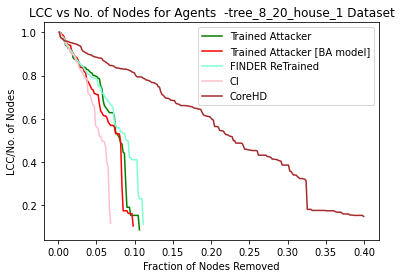

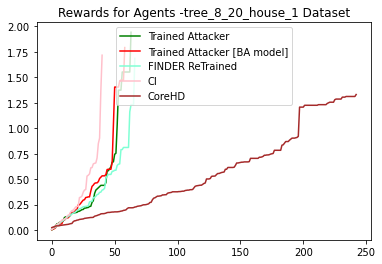

tree_8_40_house_2
[130, 377, 570, 95, 420, 113, 6, 555, 372, 493, 39, 87, 331, 422, 114, 247, 203, 135, 28, 106, 325, 552, 8, 42, 557, 40, 554, 97, 257, 550, 68, 55, 63, 120, 235, 37, 564, 273, 82, 519, 348, 25, 559, 613, 108, 33, 177, 29, 568, 137, 566, 22, 543, 505, 0, 471, 561, 350, 448, 58, 544, 31, 567, 553, 80, 551, 563, 549, 612, 164, 43, 49, 591, 214, 600, 287, 589, 629, 70, 46, 36, 590, 62, 38, 162, 85, 213, 577, 697, 627, 51, 256, 23]
[570, 95, 130, 422, 555, 40, 257, 113, 87, 2, 164, 247, 325, 557, 13, 674, 203, 69, 552, 550, 80, 554, 114, 235, 42, 55, 120, 25, 108, 48, 37, 63, 14, 162, 106, 559, 134, 33, 285, 177, 695, 519, 568, 300, 348, 93, 261, 214, 287, 139, 350, 58, 564, 566, 3, 86, 505, 471, 567, 548, 551, 256, 553, 563, 549, 448, 220, 207, 49, 561, 10, 255]


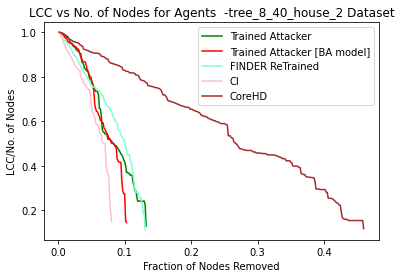

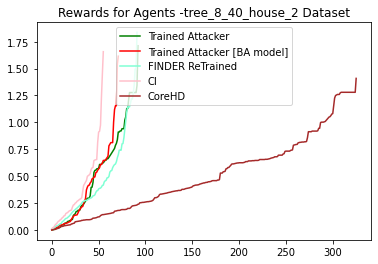

tree_8_60_house_3
[45, 56, 188, 476, 342, 421, 337, 194, 63, 276, 1, 217, 155, 30, 81, 95, 187, 258, 68, 64, 39, 70, 149, 272, 29, 111, 50, 184, 569, 585, 331, 21, 93, 593, 88, 577, 55, 37, 539, 295, 103, 123, 3, 156, 468, 586, 221, 540, 206, 241, 350, 520, 658, 239, 469, 588, 15, 574, 580, 279, 399, 450, 564, 566, 589, 590, 52, 591, 551, 169, 275, 504, 582, 253, 254, 599, 570, 40, 573, 159, 572, 12, 418, 401, 452, 189, 571, 576, 584, 601, 486, 28, 501, 575, 600, 667, 42, 208, 368, 313, 43, 282, 48, 49, 34, 36]
[763, 188, 342, 128, 56, 194, 131, 137, 187, 95, 217, 60, 155, 567, 331, 111, 236, 612, 628, 1, 61, 55, 272, 70, 156, 93, 62, 18, 166, 50, 577, 21, 569, 37, 279, 593, 149, 139, 11, 15, 82, 163, 7, 295, 239, 206, 211, 221, 520, 486, 181, 89, 435, 189, 254, 227, 203, 589, 175, 551, 571, 504, 564, 742, 570, 418, 258, 241, 566, 79, 649, 573, 34]


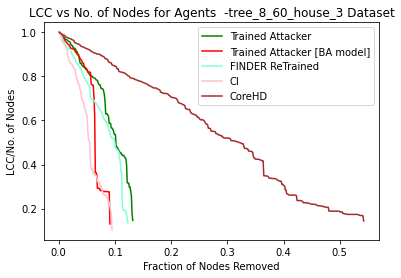

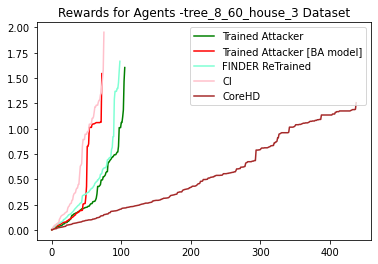

tree_8_80_house_4
[101, 520, 22, 59, 208, 31, 423, 45, 286, 97, 497, 117, 240, 156, 532, 471, 72, 406, 377, 44, 33, 1, 170, 657, 267, 56, 37, 309, 589, 46, 577, 606, 98, 129, 584, 698, 47, 635, 43, 125, 271, 54, 628, 142, 545, 79, 57, 336, 23, 474, 572, 60, 823, 582, 625, 183, 547, 446, 630, 559, 53, 602, 433, 8, 143, 583, 619, 481, 308, 297, 617, 49, 378, 581, 392, 225, 63, 610, 73, 592, 621, 612, 623, 586, 585, 254, 616, 211, 604, 624, 34, 599, 363, 608, 510, 457, 483, 311, 587, 394, 380, 615, 69, 579, 598, 620, 365, 593, 459, 614, 323, 629, 622, 12, 255, 39, 51, 48, 42, 61, 494, 68]
[423, 10, 59, 638, 97, 28, 46, 117, 497, 208, 601, 101, 156, 170, 267, 471, 406, 286, 271, 589, 98, 64, 577, 38, 56, 628, 70, 606, 24, 86, 584, 377, 14, 91, 57, 1, 239, 79, 433, 235, 140, 146, 105, 637, 127, 44, 726, 277, 8, 373, 125, 625, 60, 225, 559, 582, 250, 179, 215, 828, 336, 572, 602, 378, 174, 297, 153, 619, 610, 508, 481, 608, 578, 392, 842, 794, 106, 380, 616, 583, 365, 598, 483, 510, 581, 394

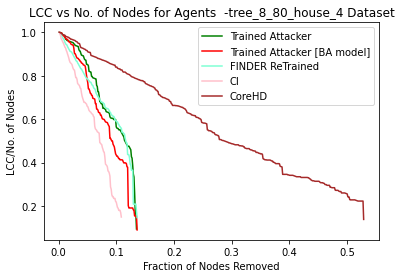

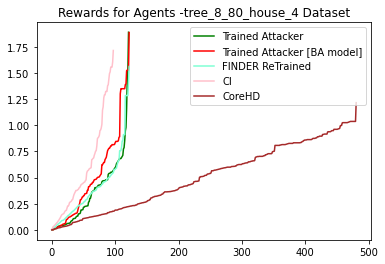

tree_8_100_house_5
[106, 305, 11, 42, 123, 307, 38, 70, 55, 172, 271, 319, 218, 72, 90, 558, 405, 263, 293, 197, 248, 609, 120, 108, 256, 182, 135, 543, 194, 363, 603, 60, 604, 611, 191, 167, 49, 89, 627, 898, 37, 69, 828, 583, 47, 39, 590, 623, 581, 78, 111, 284, 297, 2, 643, 582, 226, 648, 66, 461, 216, 122, 659, 472, 360, 640, 585, 880, 352, 160, 517, 548, 227, 534, 428, 452, 440, 923, 48, 205, 291, 252, 504, 59, 638, 416, 615, 294, 864, 221, 41, 44, 598, 629, 601, 586, 626, 620, 644, 639, 628, 484, 637, 285, 442, 342, 394, 492, 506, 536, 710, 430, 608, 105, 33, 631, 685, 13, 93, 71, 605, 614, 634, 584, 630, 494, 31, 433, 551, 3, 588, 599, 595, 591, 613, 580, 50, 587, 636, 701, 625, 147, 732, 682, 40]
[307, 27, 43, 91, 36, 11, 42, 108, 172, 39, 218, 319, 167, 135, 120, 828, 611, 271, 603, 543, 197, 288, 405, 111, 952, 604, 248, 293, 38, 58, 363, 263, 55, 256, 627, 191, 583, 609, 194, 581, 31, 347, 23, 582, 144, 66, 799, 435, 291, 72, 47, 69, 804, 118, 107, 360, 150, 93, 252, 75, 996

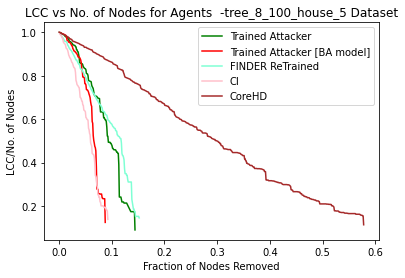

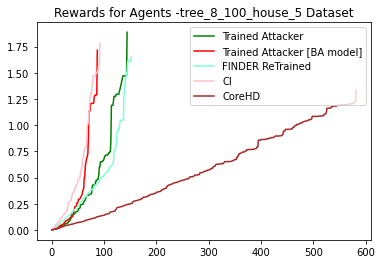

tree_8_20_fan_1
[221, 55, 399, 167, 54, 61, 63, 52, 143, 56, 21, 60, 153, 244, 165, 24, 39, 9, 449, 96, 16, 49, 22, 53, 146, 65, 37, 259, 87, 157, 283, 189, 70, 62, 57, 200, 2, 48, 185, 66, 68, 40, 33, 150, 149, 59, 69, 42, 38, 274]
[55, 61, 110, 83, 52, 56, 29, 143, 21, 133, 1, 60, 24, 165, 22, 53, 146, 243, 157, 99, 96, 255, 515, 368, 74, 139, 268, 236, 180, 37, 185, 274, 252, 35, 16, 40, 48, 57, 218, 33, 66, 270, 68, 245, 7, 38]


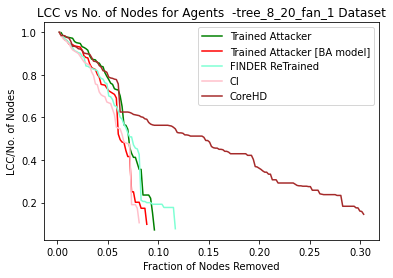

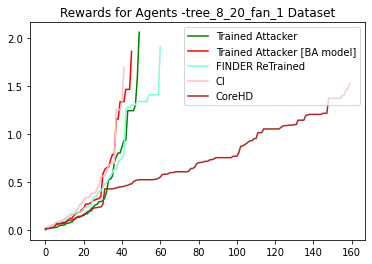

tree_8_40_fan_2
[351, 58, 6, 180, 20, 36, 16, 105, 125, 70, 83, 44, 11, 49, 468, 28, 67, 253, 39, 26, 71, 73, 108, 259, 19, 47, 68, 124, 35, 128, 131, 48, 5, 43, 69, 56, 72, 52, 209, 196, 34, 42]
[180, 58, 6, 16, 19, 20, 105, 32, 125, 67, 44, 4, 28, 49, 26, 253, 83, 73, 128, 131, 100, 68, 108, 124, 366, 117, 97, 190, 276, 110, 152, 266, 259, 137, 42, 34, 12]


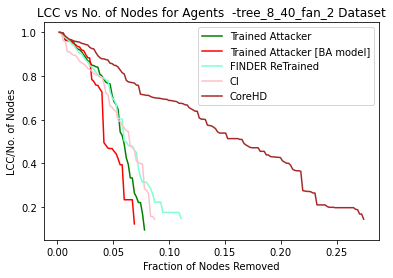

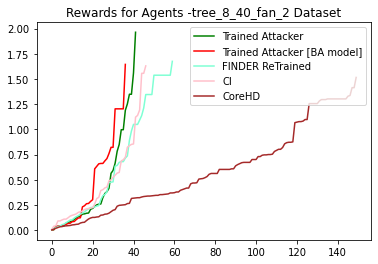

tree_8_60_fan_3
[508, 138, 485, 61, 66, 487, 26, 59, 215, 254, 228, 4, 5, 39, 270, 54, 22, 2, 57, 38, 322, 248, 71, 217, 42, 99, 62, 246, 152, 132, 47, 58, 149, 67, 278, 52, 51, 49, 64, 69, 48, 43, 40, 72, 56, 55, 157, 44, 63, 45, 202]
[8, 5, 257, 138, 61, 66, 39, 59, 52, 132, 228, 54, 110, 22, 270, 38, 48, 62, 145, 248, 57, 99, 101, 92, 322, 246, 320, 518, 74, 84, 520, 7, 166, 170, 157, 141, 154, 63, 58, 72, 40, 149, 499, 368, 111, 55, 247, 43, 174, 199, 122]


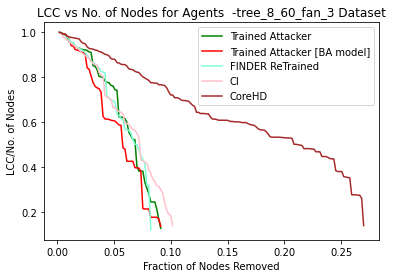

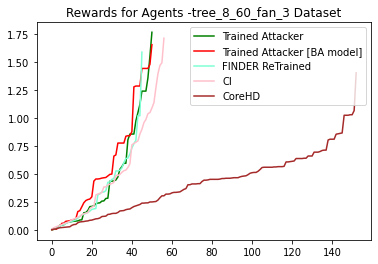

tree_8_80_fan_4
[47, 137, 479, 95, 179, 253, 123, 32, 259, 273, 149, 37, 59, 41, 55, 34, 52, 39, 50, 133, 193, 30, 60, 140, 232, 54, 40, 53, 57, 44, 17, 23, 7, 182, 33, 131, 45, 69, 4, 256, 134, 49, 80, 246, 156, 67, 238, 46, 186, 13]
[47, 123, 179, 32, 137, 149, 246, 253, 37, 95, 273, 259, 26, 41, 50, 30, 34, 52, 232, 13, 133, 40, 67, 193, 82, 60, 134, 53, 93, 80, 411, 238, 104, 125, 75, 185, 90, 81, 156, 256, 141, 5, 120, 7, 97, 131, 4, 186, 144, 54, 231, 23]


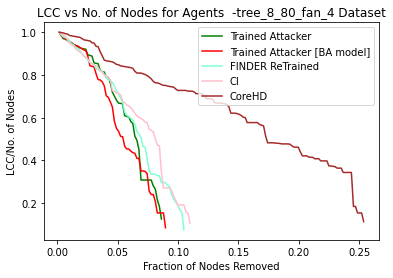

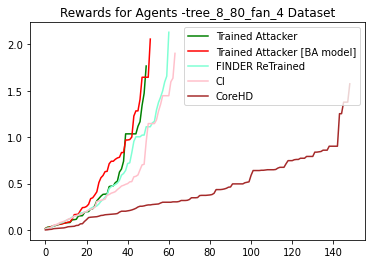

tree_8_100_fan_5
[409, 88, 192, 410, 148, 229, 10, 26, 263, 39, 252, 44, 13, 19, 57, 49, 31, 46, 68, 24, 52, 32, 37, 48, 145, 50, 565, 71, 290, 132, 198, 147, 41, 61, 56, 206, 123, 155, 271, 62, 243, 45, 450, 47, 1, 53, 66, 59, 69, 42, 54, 178, 51, 70]
[44, 214, 30, 39, 12, 192, 229, 263, 19, 14, 48, 10, 46, 50, 198, 71, 37, 117, 68, 132, 123, 134, 290, 82, 243, 61, 56, 107, 129, 112, 118, 245, 155, 49, 140, 145, 450, 222, 85, 186, 53, 151, 230, 268, 190, 169, 4]


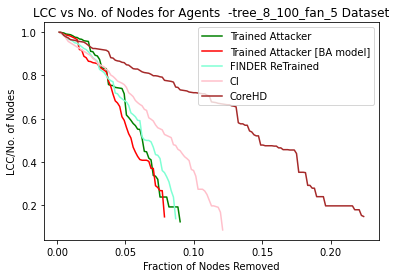

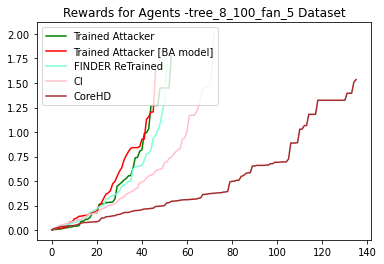

tree_8_20_clique_1
[3, 19, 260, 185, 20, 107, 187, 238, 133, 49, 56, 59, 82, 40, 65, 62, 47, 51, 137, 27, 45, 8, 7, 129, 75, 42, 134, 60, 275, 28, 44, 6, 50, 57, 63, 35, 46]
[3, 19, 133, 20, 185, 56, 187, 238, 49, 65, 6, 82, 137, 62, 59, 47, 99, 75, 107, 22, 129, 126, 174, 134, 194, 140, 171, 8, 235, 31, 12, 11, 193, 184, 45, 52, 42, 38, 67, 36, 54, 58, 44]


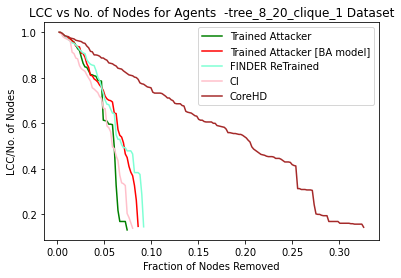

tree_8_40_clique_2
[3, 75, 382, 21, 100, 435, 117, 109, 62, 107, 118, 47, 34, 35, 163, 6, 41, 155, 11, 394, 65, 171, 37, 134, 64, 135, 137, 120, 110, 45, 265, 48, 44, 58, 52, 104, 66, 49, 63, 36, 46, 39, 57, 162, 252, 169, 0, 202, 59, 27, 38]
[3, 21, 131, 75, 117, 51, 62, 6, 163, 35, 5, 107, 135, 94, 7, 47, 118, 171, 155, 207, 224, 137, 120, 110, 223, 202, 252, 165, 159, 66, 156, 37, 212, 49, 116, 134, 53, 23, 42]


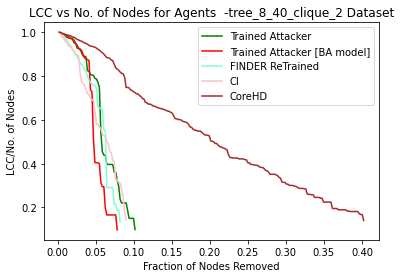

tree_8_60_clique_3
[3, 27, 26, 153, 254, 265, 61, 41, 263, 66, 67, 195, 42, 36, 53, 189, 49, 113, 62, 45, 68, 9, 73, 6, 64, 48, 71, 115, 104, 276, 155, 35, 43, 267, 65, 242, 44, 56, 39, 235, 256, 165, 11]
[3, 27, 306, 26, 254, 153, 61, 265, 32, 41, 66, 23, 36, 263, 42, 98, 140, 49, 9, 62, 123, 115, 113, 104, 483, 188, 73, 6, 155, 248, 133, 132, 112, 267, 242, 270, 174, 235, 24, 39, 15, 71, 72, 43]


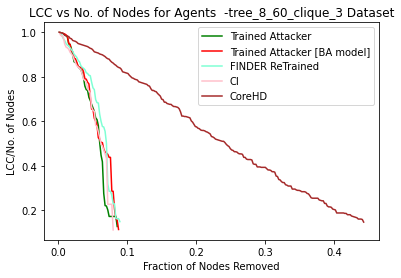

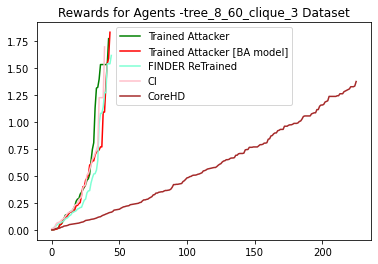

tree_8_80_clique_4
[3, 19, 62, 99, 119, 44, 33, 226, 68, 111, 255, 96, 36, 176, 48, 5, 85, 264, 265, 9, 283, 242, 54, 52, 73, 41, 30, 455, 185, 163, 112, 13, 42, 67, 64, 56, 60, 40, 55, 69, 121, 47, 63, 43]
[3, 19, 119, 62, 33, 99, 44, 68, 255, 50, 226, 1, 48, 176, 9, 111, 72, 163, 85, 501, 242, 73, 185, 248, 21, 158, 112, 28, 150, 52, 128, 30, 138, 207, 243, 42, 170, 60, 53, 34, 45, 141, 20, 264, 56, 250, 197, 347, 49]


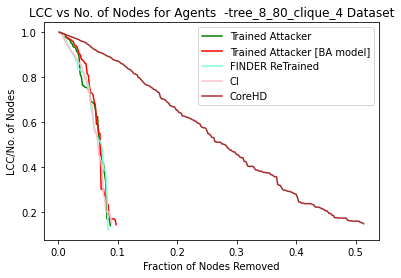

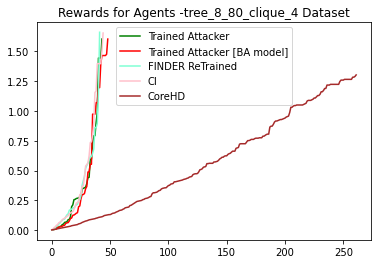

tree_8_100_clique_5
[3, 76, 383, 109, 13, 393, 61, 384, 54, 51, 6, 74, 63, 36, 10, 29, 41, 187, 8, 71, 125, 35, 179, 111, 43, 264, 45, 53, 102, 59, 261, 237, 11, 60, 73, 50, 46, 48, 260, 44, 40]
[3, 76, 6, 54, 143, 61, 63, 51, 10, 29, 36, 8, 35, 104, 125, 96, 261, 142, 79, 102, 62, 264, 179, 111, 219, 22, 195, 11, 242, 260, 251, 109, 158, 267, 165, 44, 206, 30, 37, 271, 237, 48, 40, 50, 42, 73, 172, 118, 90]


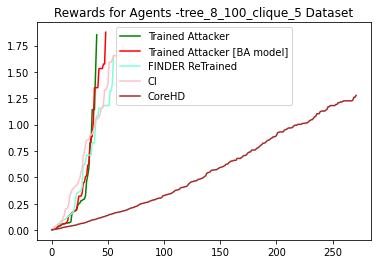

tree_8_20_diamond_1
[128, 172, 458, 532, 56, 533, 15, 102, 113, 378, 390, 523, 327, 546, 225, 541, 118, 3, 544, 543, 180, 63, 542, 275, 424, 277, 535, 536, 475, 4, 539, 53, 547, 538, 537, 545, 108, 69, 553, 562, 572, 599, 607, 618, 623, 150, 71, 13, 64, 52, 540, 67, 50, 41, 139, 261, 23, 16, 86, 200, 29, 61, 157, 49, 25, 154, 18, 252, 2, 548, 54, 38, 60, 57, 65, 51]
[172, 556, 378, 128, 458, 532, 102, 533, 607, 56, 113, 15, 610, 580, 595, 118, 626, 225, 535, 3, 544, 543, 4, 275, 108, 390, 327, 523, 546, 180, 277, 268, 536, 541, 587, 475, 27, 564, 36, 69, 150, 32, 553, 562, 572, 599, 618, 623, 41, 50, 71, 29, 78, 2, 261, 64, 131, 49, 540, 86, 23, 104, 222, 200, 154, 246, 30, 256, 48, 264, 232, 278, 114, 75, 66]


tree_8_40_diamond_2
[401, 313, 122, 148, 154, 143, 404, 587, 312, 373, 532, 46, 559, 554, 149, 421, 567, 10, 245, 194, 116, 539, 517, 565, 294, 468, 3, 347, 322, 548, 270, 568, 547, 541, 34, 222, 569, 491, 348, 550, 563, 746, 713, 588, 67, 590, 552, 652, 169, 572, 558, 560, 546, 388, 616, 622, 328, 113, 330, 89, 656, 557, 562, 681, 107, 555, 578, 687, 549, 573, 570, 29, 1, 50, 241, 556, 586, 605, 615, 621, 631, 644, 648, 665, 670, 692, 718, 741, 745, 140, 61, 226, 66, 9, 74, 12, 96, 150, 64, 41, 248, 53, 208, 68, 176, 571, 575, 57, 42, 609, 71, 55, 60, 566, 201, 564, 219, 206, 75, 239, 49, 70, 44, 51, 30, 48]
[143, 208, 313, 62, 122, 558, 148, 154, 532, 46, 149, 373, 312, 552, 248, 609, 591, 614, 116, 140, 10, 625, 113, 578, 681, 656, 294, 33, 639, 222, 616, 348, 569, 557, 468, 491, 34, 550, 563, 548, 556, 573, 562, 99, 270, 245, 169, 29, 171, 322, 571, 560, 565, 551, 554, 566, 568, 517, 241, 7, 564, 45, 1, 226, 567, 9, 404, 424, 626, 555, 547, 570, 721, 576, 150, 541, 586, 590, 592, 5

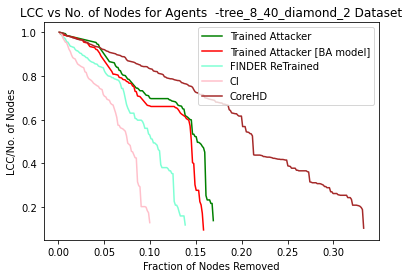

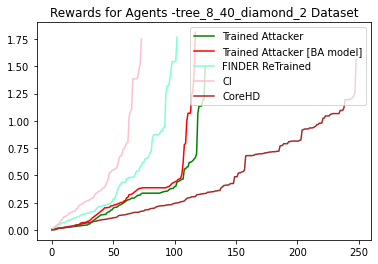

tree_8_60_diamond_3
[620, 339, 625, 110, 59, 582, 132, 602, 416, 611, 306, 580, 151, 163, 753, 177, 113, 579, 97, 320, 90, 252, 400, 446, 430, 6, 597, 599, 373, 3, 324, 608, 58, 683, 223, 157, 277, 22, 512, 478, 381, 584, 131, 586, 491, 135, 488, 54, 576, 624, 607, 598, 413, 288, 57, 305, 546, 563, 396, 865, 808, 853, 383, 168, 577, 590, 340, 271, 867, 794, 824, 384, 621, 529, 215, 188, 601, 152, 644, 615, 612, 376, 631, 461, 589, 581, 462, 854, 36, 778, 610, 593, 619, 613, 594, 13, 640, 664, 743, 454, 358, 772, 591, 585, 618, 633, 609, 606, 596, 578, 49, 38, 321, 234, 639, 649, 650, 657, 662, 676, 700, 705, 723, 728, 762, 767, 816, 829, 35, 40, 29, 37, 44, 69, 505, 622, 41, 31, 626, 627, 42, 218, 262, 507, 169, 120, 39, 127, 28, 81, 174, 46, 71, 67, 50, 237, 201, 583, 801, 184, 654, 717, 1, 68, 60, 47, 48, 62, 183, 70]
[620, 625, 321, 59, 592, 611, 81, 621, 785, 600, 163, 583, 599, 177, 113, 782, 233, 110, 6, 825, 400, 340, 629, 324, 686, 73, 639, 749, 132, 36, 56, 90, 717, 819, 597, 

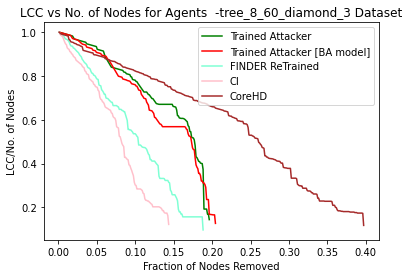

tree_8_80_diamond_4
[348, 349, 690, 182, 96, 87, 132, 615, 86, 364, 586, 732, 318, 185, 322, 351, 80, 498, 598, 424, 30, 114, 166, 449, 223, 304, 330, 267, 365, 423, 295, 241, 571, 527, 90, 390, 629, 347, 93, 212, 647, 290, 394, 632, 551, 606, 362, 630, 611, 625, 522, 324, 872, 552, 910, 226, 64, 653, 639, 612, 523, 474, 156, 540, 865, 555, 635, 420, 480, 198, 461, 334, 524, 19, 631, 624, 693, 652, 60, 111, 142, 580, 448, 636, 637, 648, 850, 949, 908, 650, 477, 689, 323, 366, 279, 810, 169, 666, 605, 655, 502, 596, 227, 331, 499, 640, 254, 761, 762, 654, 614, 638, 549, 81, 621, 604, 566, 46, 439, 56, 814, 76, 897, 634, 597, 610, 613, 619, 107, 184, 925, 377, 3, 717, 532, 417, 775, 440, 206, 617, 633, 711, 726, 645, 607, 919, 641, 701, 804, 855, 608, 622, 651, 602, 603, 54, 71, 72, 47, 984, 675, 700, 643, 990, 688, 859, 727, 744, 753, 799, 822, 878, 932, 940, 957, 981, 15, 52, 65, 57, 27, 591, 103, 17, 14, 189, 21, 22, 297, 28, 186, 618, 593, 214, 234, 222, 18, 691, 220, 784, 251, 823, 

tree_8_100_diamond_5
[149, 52, 130, 94, 146, 355, 44, 365, 109, 273, 223, 104, 701, 92, 211, 313, 406, 247, 621, 563, 171, 842, 616, 22, 519, 374, 212, 954, 479, 105, 612, 57, 122, 132, 596, 653, 1093, 278, 5, 555, 127, 240, 465, 746, 409, 753, 617, 494, 650, 607, 68, 928, 4, 606, 491, 309, 739, 258, 1094, 581, 244, 550, 654, 14, 539, 120, 325, 358, 347, 682, 574, 468, 502, 445, 652, 631, 587, 571, 582, 626, 551, 622, 642, 674, 667, 268, 370, 183, 595, 80, 170, 17, 336, 584, 3, 662, 641, 640, 610, 608, 678, 1084, 1077, 680, 630, 685, 872, 234, 676, 1010, 637, 859, 804, 645, 655, 651, 1049, 1028, 532, 806, 783, 658, 862, 972, 30, 669, 93, 514, 383, 737, 310, 683, 646, 989, 648, 629, 657, 609, 684, 544, 624, 813, 198, 394, 880, 725, 527, 661, 526, 798, 927, 773, 679, 668, 638, 615, 671, 957, 632, 31, 143, 476, 108, 289, 511, 663, 561, 611, 743, 877, 733, 643, 618, 817, 634, 904, 619, 665, 672, 625, 140, 18, 95, 60, 691, 696, 24, 707, 720, 21, 752, 758, 790, 795, 824, 837, 853, 858, 867, 

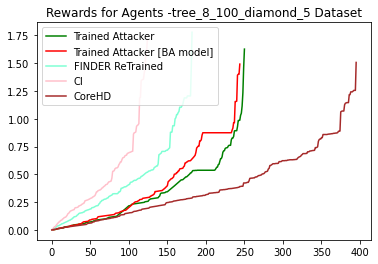

tree_8_20_cycle_1
[54, 53, 131, 1, 227, 82, 16, 104, 40, 15, 47, 22, 59, 39, 19, 65, 49, 183, 2, 414, 45, 63, 50, 234, 61]
[28, 5, 53, 2, 131, 79, 82, 235, 104, 150, 156, 183, 259, 187, 9, 31, 208, 212, 11, 49, 234, 38, 65, 34]


tree_8_40_cycle_2
[102, 90, 37, 64, 25, 40, 27, 132, 22, 60, 80, 51, 127, 38, 8, 66, 41, 56, 30, 115, 154, 116, 34, 384, 48, 216, 44, 389, 2]
[412, 413, 90, 414, 415, 102, 13, 40, 22, 25, 38, 64, 51, 76, 132, 115, 127, 80, 490, 242, 116, 170, 216, 8, 192, 14, 268, 140, 152, 270, 10, 194, 204, 178, 226, 228, 254]


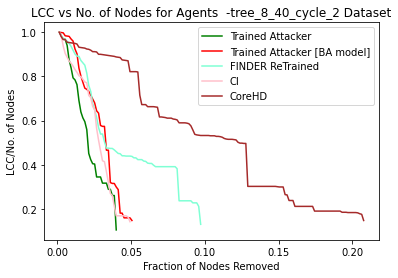

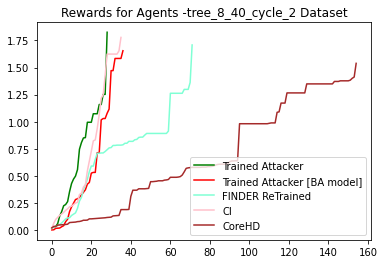

tree_8_60_cycle_3
[39, 53, 9, 463, 501, 66, 44, 48, 54, 57, 63, 36, 71, 4, 107, 45, 29, 50, 68, 42, 124, 46, 64, 37, 55, 35, 117, 278, 233, 180, 2]
[231, 10, 53, 18, 27, 66, 48, 45, 29, 80, 63, 35, 1, 71, 124, 89, 107, 116, 75, 81, 117, 244, 205, 142, 278, 277, 223, 170, 188, 258, 207, 275, 178, 213, 268, 171, 31, 241, 249, 189, 225, 47]


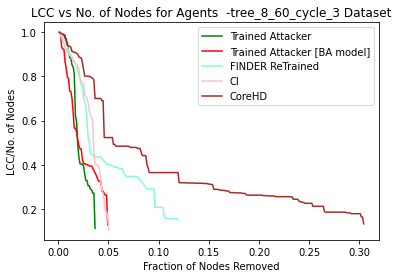

tree_8_80_cycle_4
[487, 61, 9, 114, 35, 58, 54, 37, 67, 43, 47, 63, 50, 488, 113, 2, 41, 51, 545, 46, 60, 38, 48, 134, 56, 80, 64, 141, 84, 53, 8, 250, 254, 181, 394, 243, 287, 408, 258, 301, 419, 55, 325, 540, 14, 462, 237, 52]
[244, 4, 14, 43, 35, 28, 123, 58, 48, 41, 54, 67, 101, 128, 103, 74, 114, 7, 134, 91, 107, 84, 94, 80, 181, 113, 201, 141, 243, 196, 254, 154, 142, 264, 270, 462, 195, 257, 147, 237, 160, 188, 215, 12, 283, 65, 8]


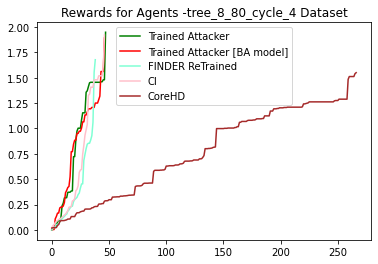

tree_8_100_cycle_5
[487, 496, 45, 164, 425, 12, 36, 51, 63, 50, 146, 59, 40, 35, 62, 53, 33, 66, 49, 47, 349, 56, 54, 57, 61, 250, 38, 42, 29, 1, 512, 70, 67, 92, 58, 252, 64, 46, 68, 284, 182, 52, 228, 81, 216, 245, 346, 234, 267, 369, 239, 204, 261, 193, 162, 198, 221, 256]
[45, 245, 250, 13, 51, 26, 66, 164, 31, 40, 34, 22, 49, 57, 128, 73, 69, 117, 304, 87, 305, 310, 308, 76, 17, 267, 11, 427, 140, 81, 138, 111, 92, 105, 228, 99, 221, 261, 162, 513, 216, 146, 647, 176, 198, 231, 244, 159, 182, 255, 112, 239, 204, 152, 266, 233, 289, 278, 187, 209, 272]


tree_8_20_star_1
[71, 225, 274, 21, 30, 98, 59, 66, 12, 149, 9, 379, 418, 73, 49, 16, 245, 56, 113, 101, 46, 125, 206, 104, 237, 1, 145, 7, 118, 47, 69, 37, 72, 187, 50, 42, 39, 45, 53]
[71, 21, 59, 30, 225, 50, 142, 12, 9, 245, 16, 149, 7, 46, 96, 113, 66, 37, 168, 109, 125, 101, 104, 1, 237, 210, 118, 163, 23, 259, 190, 72, 57, 230, 192, 40, 68, 53]


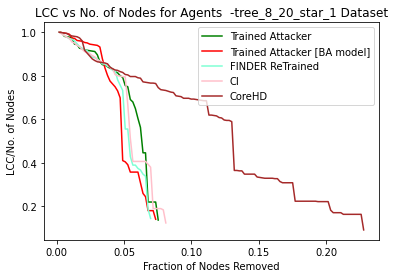

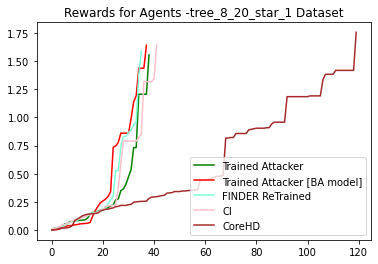

tree_8_40_star_2
[130, 61, 92, 86, 16, 193, 55, 87, 408, 215, 545, 41, 83, 27, 238, 0, 65, 28, 49, 53, 22, 48, 67, 152, 18, 158, 105, 31, 44, 39, 51, 68, 186, 178, 227, 62, 174, 163, 71, 69, 72, 40, 237, 50, 43, 222, 64, 54]
[130, 28, 0, 43, 16, 92, 55, 98, 238, 215, 41, 27, 65, 18, 83, 22, 53, 67, 95, 152, 105, 71, 200, 15, 89, 114, 177, 190, 159, 149, 125, 12, 227, 68, 38, 4, 187, 202, 163, 54, 237, 72, 189, 266, 87, 47, 50, 51]


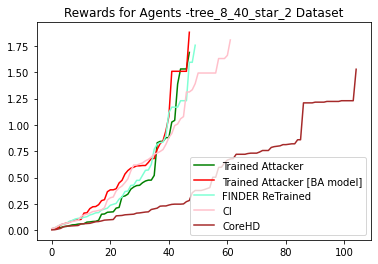

tree_8_60_star_3
[325, 80, 227, 172, 107, 200, 142, 126, 43, 235, 271, 21, 193, 97, 210, 65, 118, 36, 12, 22, 42, 64, 218, 188, 9, 54, 33, 119, 24, 62, 91, 145, 37, 283, 51, 61, 69, 38, 44, 141, 240, 56, 98, 68, 58, 41, 52, 253, 2]
[80, 227, 43, 107, 126, 10, 235, 200, 142, 32, 12, 218, 172, 271, 36, 102, 45, 17, 97, 118, 193, 108, 119, 42, 132, 90, 124, 228, 99, 275, 9, 34, 116, 134, 72, 240, 191, 266, 253, 141, 283, 278, 56, 25, 81, 263, 50, 6, 30, 41, 150, 152, 158, 280, 181, 125]


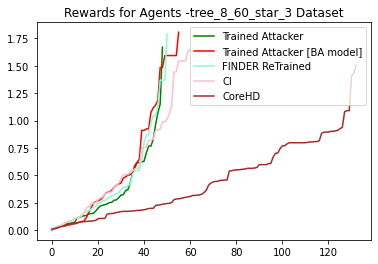

tree_8_80_star_4
[41, 311, 312, 97, 547, 541, 174, 261, 7, 313, 51, 55, 278, 146, 29, 21, 155, 206, 108, 36, 33, 50, 28, 224, 48, 109, 27, 494, 67, 585, 46, 37, 222, 149, 43, 66, 39, 42, 241, 262, 1, 98, 49, 34, 45, 57, 69, 68, 231, 220, 38, 252, 180, 245, 173, 277, 268, 60]
[51, 97, 41, 217, 7, 55, 133, 281, 174, 29, 36, 42, 108, 33, 50, 67, 80, 28, 278, 27, 91, 48, 215, 112, 85, 191, 254, 34, 160, 149, 240, 98, 196, 5, 231, 120, 92, 38, 140, 126, 45, 20, 147, 252, 49, 427, 68]


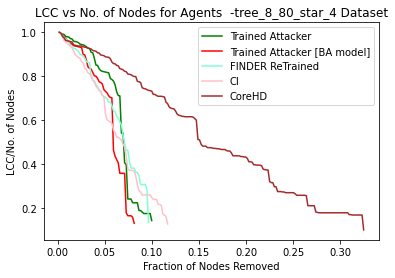

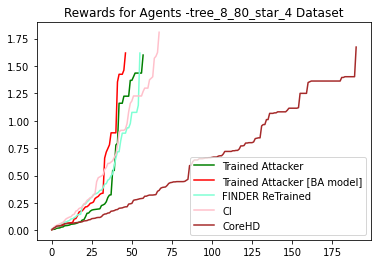

tree_8_100_star_5
[387, 186, 120, 293, 67, 58, 87, 201, 159, 154, 65, 34, 94, 254, 261, 176, 50, 44, 28, 69, 133, 39, 64, 62, 151, 22, 26, 84, 49, 156, 149, 54, 1, 258, 68, 216, 294, 6, 170, 147, 241, 46, 43, 63, 41, 203, 274, 38, 281, 55, 61, 184, 35, 51, 52, 57, 287, 48, 53, 40, 207, 56, 275, 266, 165, 191, 177]
[120, 28, 89, 293, 67, 31, 34, 87, 159, 11, 154, 201, 254, 62, 69, 44, 133, 50, 55, 176, 39, 22, 147, 73, 261, 128, 6, 294, 106, 156, 84, 200, 129, 100, 134, 123, 78, 111, 287, 94, 118, 170, 241, 275, 274, 203, 4]


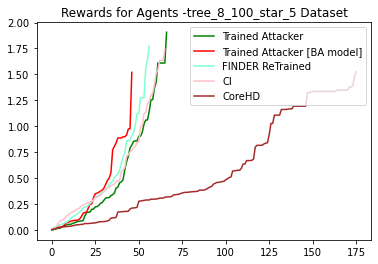

tree_8_20_grid_1
[315, 867, 654, 431, 595, 476, 589, 517, 590, 1050, 755, 649, 833, 588, 990, 800, 125, 577, 736, 798, 1079, 177, 618, 18, 708, 1153, 982, 1213, 234, 688, 36, 672, 574, 959, 793, 864, 926, 62, 992, 1016, 696, 767, 709, 883, 648, 724, 71, 1126, 615, 579, 1219, 277, 924, 824, 60, 19, 1142, 563, 1196, 663, 1160, 693, 943, 662, 1014, 1023, 1072, 613, 726, 193, 567, 774, 872, 1074, 246, 14, 813, 231, 1176, 73, 817, 684, 28, 888, 570, 847, 955, 852, 710, 738, 164, 147, 49, 326, 1097, 976, 868, 889, 885, 554, 901, 994, 805, 750, 1164, 789, 1189, 622, 599, 1204, 1045, 21, 837, 1087, 53, 677, 701, 57, 944, 1155, 59, 913, 1119, 1069, 558, 70, 1215, 242, 754, 92, 606, 598, 1006, 1101, 821, 735, 853, 1026, 1222, 217, 1179, 715, 635, 871, 1187, 973, 690, 691, 580, 128, 668, 602, 281, 292, 946, 347, 90, 203, 1139, 763, 593, 68, 921, 658, 933, 38, 270, 1062, 900, 1049, 61, 568, 201, 979, 1198, 55, 802, 226, 75, 720, 0, 215, 1038, 1081, 1111, 564, 58, 1183, 582, 897, 173, 686, 695, 22,

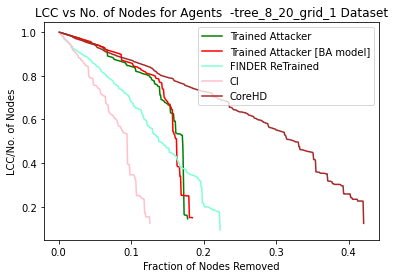

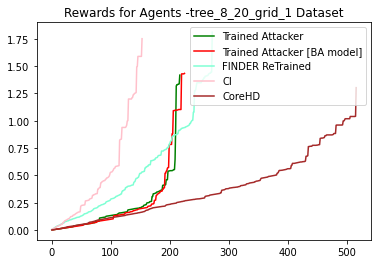

tree_8_40_grid_2
[551, 290, 627, 310, 105, 720, 625, 710, 167, 843, 1252, 763, 639, 857, 651, 837, 793, 597, 87, 789, 712, 89, 901, 1876, 649, 781, 422, 1453, 198, 1570, 624, 1080, 919, 64, 297, 1845, 1278, 1799, 970, 994, 654, 1427, 634, 1597, 957, 1126, 804, 1223, 648, 91, 1057, 1778, 1776, 1247, 875, 827, 742, 864, 1270, 25, 841, 600, 978, 1744, 1452, 1931, 1850, 1473, 1149, 767, 1901, 718, 592, 1104, 1046, 6, 30, 1255, 846, 719, 1284, 1545, 325, 586, 1075, 72, 747, 768, 1398, 57, 1036, 824, 1066, 48, 1320, 1358, 1706, 675, 1183, 797, 977, 604, 1217, 689, 810, 1592, 954, 1645, 294, 1282, 1750, 643, 1069, 1338, 874, 1774, 1714, 612, 1823, 598, 236, 1514, 1686, 24, 698, 1116, 1437, 1019, 749, 587, 1157, 993, 1886, 532, 299, 659, 1394, 1041, 1086, 1541, 1481, 32, 1295, 1211, 796, 1943, 46, 1291, 220, 1127, 75, 19, 632, 989, 602, 601, 1840, 1085, 645, 1172, 58, 1457, 53, 1387, 636, 1906, 616, 1716, 1318, 851, 1593, 730, 1034, 623, 356, 1028, 1501, 603, 1063, 1327, 826, 640, 669, 1178, 1

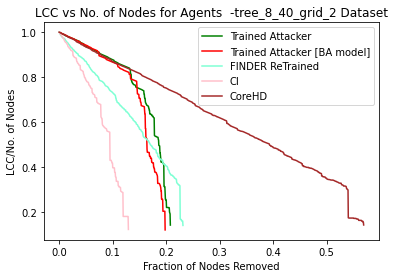

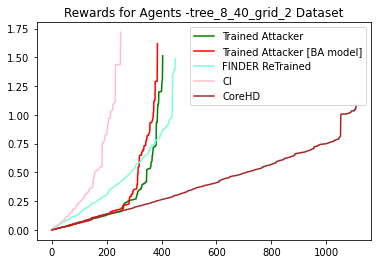

tree_8_60_grid_3
[704, 187, 604, 1453, 691, 148, 758, 1156, 48, 970, 159, 621, 178, 1002, 457, 735, 771, 145, 357, 813, 574, 1316, 1560, 1003, 856, 640, 617, 770, 1039, 1264, 1188, 1706, 2357, 1418, 1851, 808, 1374, 2483, 1802, 1015, 1060, 1640, 651, 826, 1223, 742, 1792, 1053, 200, 692, 1149, 1909, 905, 2427, 946, 2276, 1182, 1110, 2217, 1368, 476, 2159, 767, 1293, 1270, 995, 1573, 215, 1915, 952, 33, 2068, 254, 1198, 2469, 1869, 2101, 1265, 2506, 1776, 622, 1742, 724, 961, 666, 843, 247, 675, 1697, 920, 1721, 783, 2154, 895, 688, 2585, 469, 1042, 2465, 741, 1472, 204, 1531, 225, 1154, 140, 965, 1231, 2611, 261, 1625, 1876, 2664, 1844, 2274, 2457, 2393, 685, 409, 1668, 636, 1691, 1255, 992, 603, 1880, 1645, 1079, 2251, 448, 2485, 1530, 1299, 20, 2418, 2302, 815, 885, 1562, 1756, 1904, 1077, 432, 1634, 2219, 630, 509, 1771, 1347, 1184, 302, 1371, 1063, 626, 1317, 825, 699, 1151, 2034, 1611, 756, 1438, 1136, 2066, 1837, 1225, 59, 2188, 1036, 1402, 49, 555, 676, 1672, 660, 2370, 2258, 96

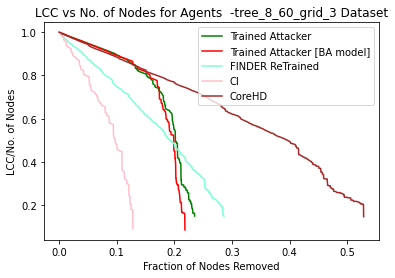

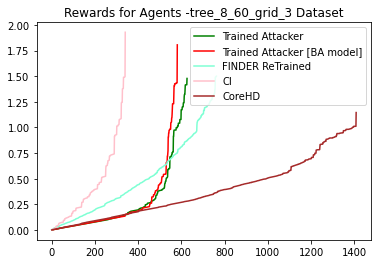

In [35]:
file_list = ['tree_8_20_house_1', 'tree_8_40_house_2', 'tree_8_60_house_3', 'tree_8_80_house_4', 'tree_8_100_house_5', 'tree_8_20_fan_1', 'tree_8_40_fan_2', 'tree_8_60_fan_3', 'tree_8_80_fan_4', 'tree_8_100_fan_5', 'tree_8_20_clique_1', 'tree_8_40_clique_2', 'tree_8_60_clique_3', 'tree_8_80_clique_4', 'tree_8_100_clique_5', 'tree_8_20_diamond_1', 'tree_8_40_diamond_2', 'tree_8_60_diamond_3', 'tree_8_80_diamond_4', 'tree_8_100_diamond_5', 'tree_8_20_cycle_1', 'tree_8_40_cycle_2', 'tree_8_60_cycle_3', 'tree_8_80_cycle_4', 'tree_8_100_cycle_5', 'tree_8_20_star_1', 'tree_8_40_star_2', 'tree_8_60_star_3', 'tree_8_80_star_4', 'tree_8_100_star_5', 'tree_8_20_grid_1', 'tree_8_40_grid_2', 'tree_8_60_grid_3','tree_8_80_grid_4', 'tree_8_100_grid_5']
graph_path ="./Dataset/Validation/Motifs_Attached/Tree/" 
AUC = visual_evaluation(graph_path,file_list,[attacker[0],parameter[0]],[attacker[1],parameter[1]])

In [38]:
file = ['differentGraph','BAGraph','FinderReTrained','CI','CoreHD']
print('Test Name','\t\t','Mix','\t','BA','\t','FIN','\t','CI''\t','CoreHD''\t','BEST')
for i, element in enumerate(AUC):
    for nested_tem in element:
        if isinstance(nested_tem, str): 
            print(nested_tem, end=" => \t")
        else:
            print("{:.2f}".format(nested_tem), end=" \t")
    
    best = np.argmin(np.array(element[1:]).astype(float))
    print(file[best])
    print("")
print("===============================")

Test Name 		 Mix 	 BA 	 FIN 	 RAND	 BEST
tree_8_80_grid_4 => 	641.86 	580.90 	610.63 	285.49 	1218.18 	CI

tree_8_100_grid_5 => 	792.61 	770.72 	784.45 	371.55 	1487.73 	CI



# New Synthetic Mortif

ba_60_10_house_1
[6, 0, 12, 9, 11, 8, 16, 19, 10, 5, 2, 24, 13, 44, 43, 46, 45, 1, 56, 54, 15, 21, 38, 40, 64, 70, 69]
[0, 6, 12, 9, 11, 8, 16, 19, 13, 5, 2, 24, 10, 46, 44, 43, 38, 1, 21, 45, 15, 54, 56, 64, 69, 71, 70]


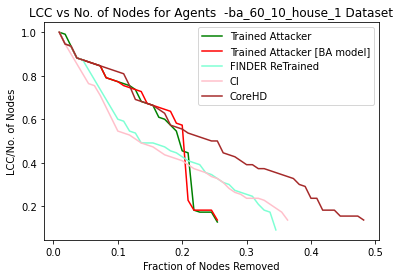

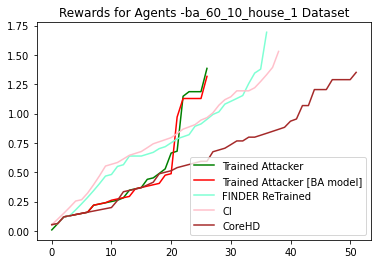

ba_60_20_house_2
[0, 47, 6, 1, 9, 8, 11, 10, 51, 7, 17, 59, 25, 2, 48, 61, 3, 5, 13, 74, 70, 76, 19, 78, 71, 79, 80, 66, 73, 146, 29, 14, 67, 42, 128, 72]
[0, 47, 6, 1, 9, 8, 11, 7, 10, 51, 17, 61, 25, 59, 3, 48, 13, 2, 5, 74, 146, 29, 72, 78, 67, 79, 66, 71, 73, 68, 80]


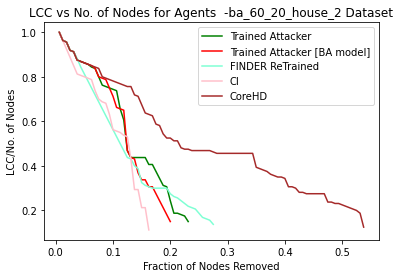

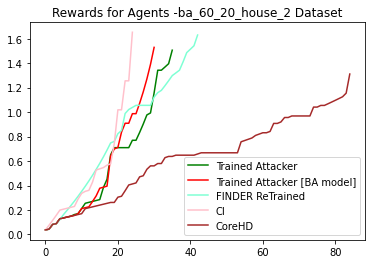

ba_60_30_house_3
[0, 6, 11, 7, 9, 36, 2, 12, 15, 1, 28, 29, 45, 5, 8, 13, 16, 24, 27, 53, 14, 41, 46, 43, 52, 47, 34, 114, 18, 37, 78, 82, 86, 35, 74, 44]
[0, 6, 11, 36, 9, 7, 28, 45, 1, 46, 15, 12, 8, 37, 27, 29, 13, 43, 2, 44, 52, 47, 34, 64, 4, 139, 5, 32, 208]


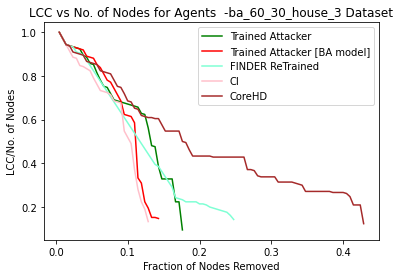

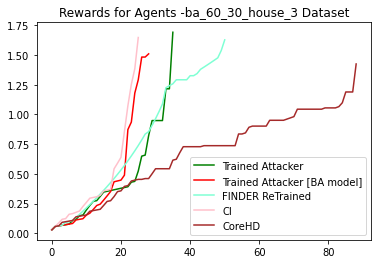

ba_60_10_fan_1
[0, 7, 5, 6, 44, 10, 22, 12, 35, 17, 9, 13, 24, 42, 11, 26, 47, 8, 32, 20, 45, 14, 48, 15, 55, 25, 1, 3, 40, 39]
[0, 7, 5, 6, 44, 10, 22, 9, 17, 35, 12, 13, 8, 42, 24, 48, 14, 11, 45, 26, 32, 47, 20, 15, 28, 3]


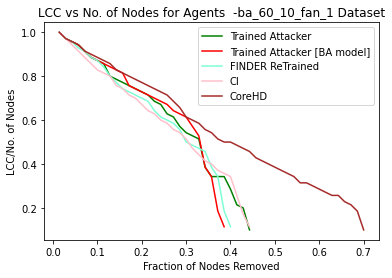

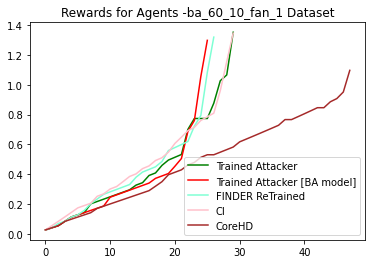

ba_60_20_fan_2
[0, 6, 12, 11, 40, 32, 10, 8, 38, 2, 7, 34, 13, 43, 17, 16, 9, 20, 41, 28, 14, 5, 4, 70, 18, 15, 55, 42, 29, 3]
[0, 6, 12, 32, 8, 11, 40, 10, 38, 2, 4, 7, 13, 34, 17, 43, 20, 16, 9, 63, 70, 28, 19, 18, 22, 29, 15]


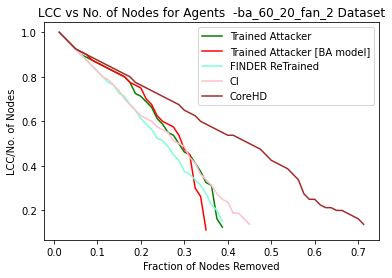

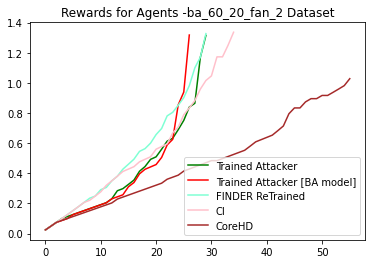

ba_60_30_fan_3
[6, 7, 2, 0, 8, 26, 9, 11, 46, 1, 35, 23, 12, 38, 25, 10, 48, 17, 13, 54, 3, 55, 50, 15, 14, 61, 53, 52]
[6, 2, 7, 0, 8, 26, 9, 1, 46, 11, 23, 35, 12, 25, 3, 38, 13, 54, 17, 55, 50, 10, 49, 64, 14, 48]


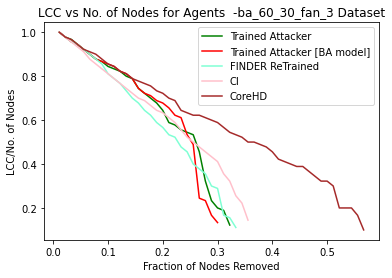

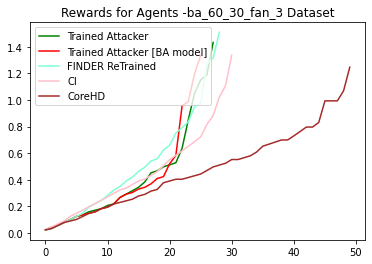

ba_60_10_clique_1
[6, 37, 0, 3, 1, 5, 11, 38, 8, 10, 25, 49, 23, 7, 15, 58, 39, 27, 28, 44, 56, 18, 14, 42, 2, 40]
[6, 37, 0, 3, 5, 1, 11, 38, 8, 10, 49, 25, 23, 7, 27, 58, 39, 15, 28, 22, 42, 14, 12, 40, 18]


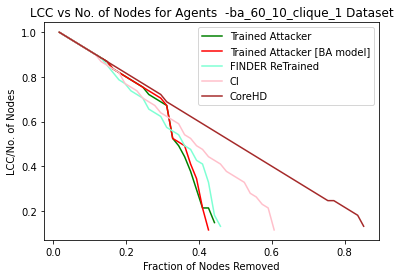

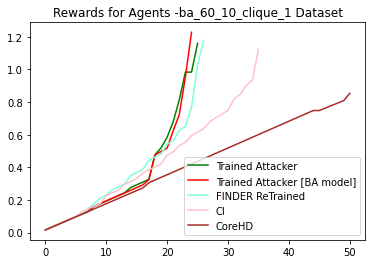

ba_60_20_clique_2
[9, 6, 20, 21, 47, 0, 23, 8, 2, 1, 3, 25, 7, 10, 40, 50, 13, 12, 38, 35, 48, 36, 54, 46, 43, 26, 51, 55, 41, 14, 32, 60, 58, 16]
[9, 6, 0, 23, 20, 21, 8, 1, 2, 3, 7, 40, 25, 10, 13, 12, 46, 38, 35, 36, 50, 48, 14, 54, 16, 55, 26, 11]


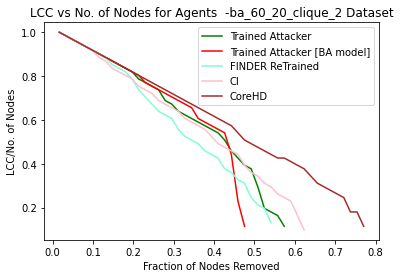

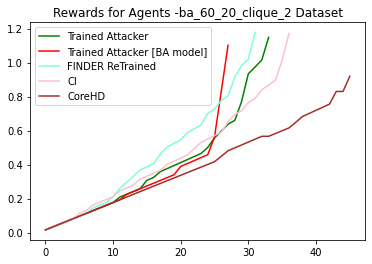

ba_60_30_clique_3
[20, 6, 7, 8, 23, 9, 0, 10, 13, 2, 11, 36, 22, 48, 21, 60, 52, 4, 56, 16, 34, 57, 15, 14, 19, 18, 58, 54, 5]
[6, 20, 7, 8, 9, 23, 0, 10, 2, 13, 11, 36, 22, 48, 60, 21, 52, 19, 58, 34, 4, 40, 16, 56, 14, 53, 35, 55]


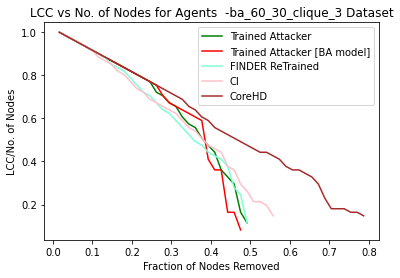

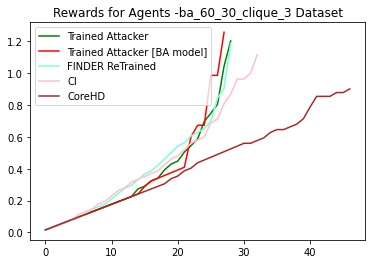

ba_60_10_diamond_1
[7, 0, 45, 3, 6, 10, 43, 8, 27, 9, 15, 36, 13, 5, 44, 12, 11, 30, 26, 34, 69, 2, 63, 70, 67, 110, 68, 65, 72, 71, 81, 17, 16, 66, 91, 96, 105, 114, 119, 52, 80, 60, 86, 55]
[7, 0, 3, 45, 10, 6, 8, 43, 27, 9, 36, 15, 5, 13, 44, 51, 2, 114, 12, 71, 26, 78, 34, 69, 96, 70, 110, 11, 91, 105, 30, 60, 66, 68, 63, 65, 67, 16, 72, 86, 81, 79, 119, 17, 49]


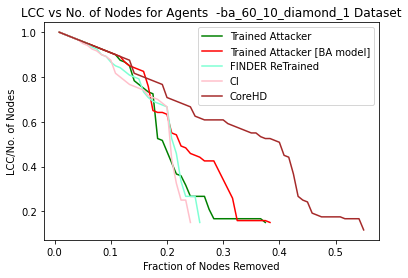

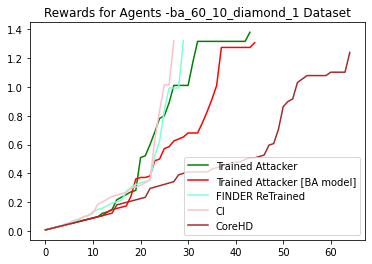

ba_60_20_diamond_2
[6, 13, 11, 8, 0, 22, 23, 45, 7, 15, 5, 10, 36, 61, 4, 9, 26, 1, 14, 42, 57, 30, 73, 76, 82, 117, 67, 63, 69, 28, 72, 74, 31, 47, 59, 79, 80, 83, 21, 84, 141, 93, 107, 49, 98, 122, 50, 99, 137, 146, 66, 112, 165, 170, 171, 179, 70, 127, 71, 75, 132, 151, 77, 155, 78, 160, 18, 41]
[6, 13, 11, 8, 0, 45, 22, 7, 23, 15, 5, 10, 36, 61, 4, 9, 26, 14, 35, 88, 57, 81, 73, 67, 137, 165, 179, 28, 63, 74, 80, 21, 49, 50, 66, 69, 70, 133, 71, 75, 78, 79, 82, 53, 42, 30, 43, 155, 38, 140, 87, 99, 93, 98, 107, 112, 117, 122, 127, 132, 146, 151, 160, 170, 174, 134, 77, 68, 1]


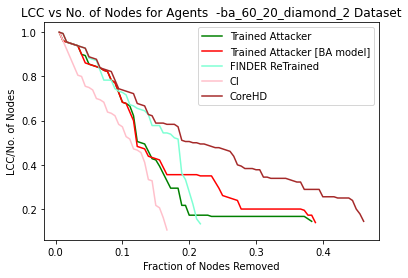

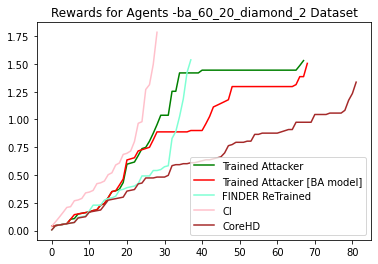

ba_60_30_diamond_3
[0, 2, 7, 8, 10, 6, 9, 1, 4, 16, 30, 28, 40, 34, 12, 5, 14, 11, 27, 3, 18, 45, 66, 43, 32, 31, 76, 74, 85, 91, 87, 70, 77, 89, 197, 81, 84, 67, 29, 234, 90, 222, 51, 38, 13]
[0, 2, 8, 10, 7, 6, 1, 9, 4, 16, 28, 30, 11, 40, 14, 12, 34, 66, 43, 45, 106, 31, 153, 54, 176, 234, 85, 87, 67, 79, 91, 89, 83, 74, 70, 77, 80, 84, 174, 90, 26, 48, 51, 56, 61, 63, 65, 71, 72, 73, 75, 78, 81, 133, 60]


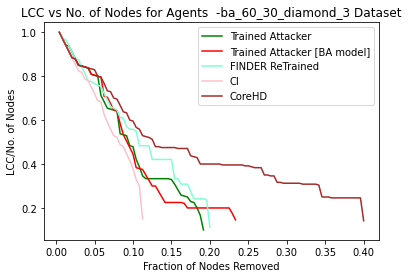

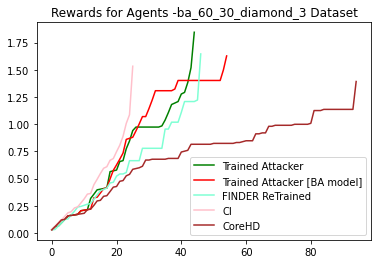

ba_60_10_star_1
[2, 24, 6, 0, 10, 7, 14, 4, 12, 11, 8, 30, 27, 20, 48, 28, 50, 19, 13, 43, 35, 16, 33, 61, 9, 42, 40, 51]
[2, 6, 24, 0, 10, 7, 4, 14, 20, 12, 27, 8, 30, 11, 28, 48, 13, 50, 19, 43, 61, 16, 33, 35, 38]


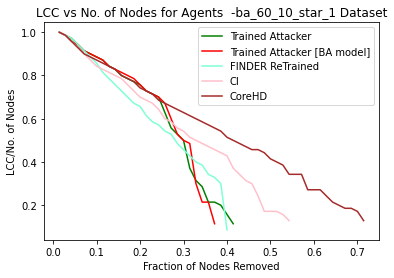

ba_60_20_star_2
[6, 7, 0, 8, 38, 11, 10, 3, 14, 45, 30, 31, 13, 63, 9, 49, 2, 53, 41, 52, 17, 16, 28, 19, 62, 47, 57, 58]
[6, 7, 0, 8, 38, 10, 11, 45, 14, 3, 30, 31, 49, 55, 62, 2, 63, 68, 9, 54, 53, 13, 4, 28, 41, 17]


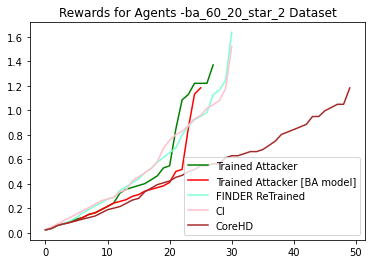

ba_60_30_star_3
[0, 5, 17, 1, 14, 9, 7, 3, 6, 8, 36, 18, 51, 10, 35, 42, 46, 19, 16, 55, 63, 22, 24, 59, 13, 45, 2, 31, 48, 52, 54]
[0, 5, 7, 14, 1, 17, 9, 3, 6, 51, 8, 18, 36, 10, 42, 35, 46, 65, 19, 16, 54, 63, 45, 41, 33, 2, 20, 48, 24, 22]


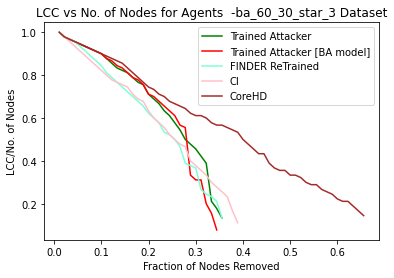

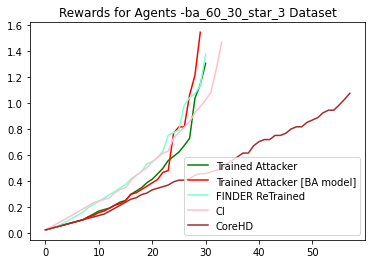

ba_60_10_grid_1
[7, 25, 1, 0, 6, 23, 42, 39, 24, 12, 40, 28, 26, 11, 9, 14, 10, 19, 8, 51, 120, 20, 41, 32, 70, 31, 4, 47]
[7, 25, 1, 6, 0, 23, 42, 39, 24, 12, 9, 40, 41, 28, 11, 10, 26, 19, 20, 8, 51, 31, 120, 70, 47, 89, 14, 129, 137, 114, 74, 81, 98, 106, 27, 17]


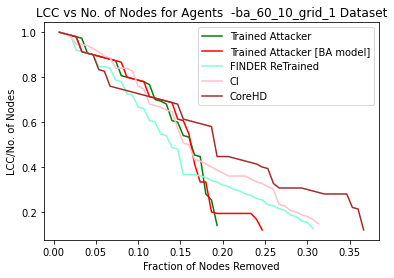

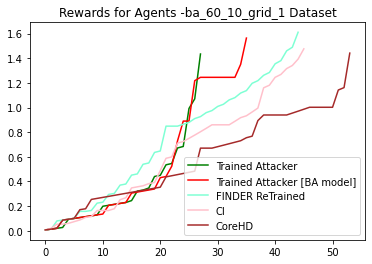

ba_60_20_grid_2
[0, 9, 29, 7, 13, 5, 17, 20, 21, 24, 18, 28, 32, 6, 10, 4, 12, 16, 14, 19, 27, 26, 2, 15, 33, 35, 50, 177, 3, 34, 53, 48, 178, 8, 61, 80, 55, 58, 45]
[0, 32, 5, 29, 6, 10, 7, 9, 4, 35, 27, 33, 55, 26, 38, 15, 40, 8, 12, 25, 51, 41, 61, 85, 87, 89, 121, 80, 203, 31, 92, 219, 211, 195, 116, 234, 164, 156, 226, 187, 100, 108, 132, 140, 148, 172, 179, 11, 3, 123, 39, 50]


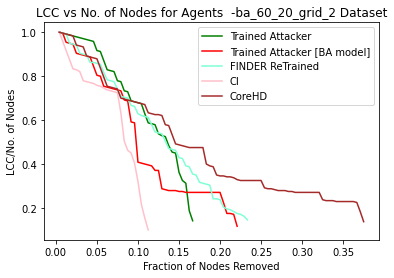

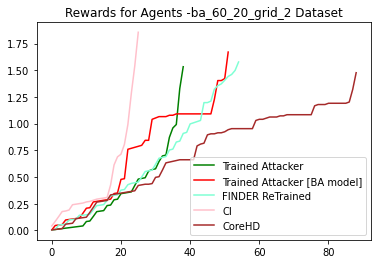

ba_60_30_grid_3
[0, 4, 5, 6, 2, 3, 7, 1, 8, 9, 10, 13, 33, 34, 43, 44, 54, 51, 14, 17, 26, 23, 27, 28, 31, 15, 20, 35, 57, 46, 37, 56, 45, 58, 69, 11, 48, 80, 55, 19, 42]
[6, 0, 5, 7, 8, 26, 43, 2, 1, 4, 27, 10, 9, 35, 31, 64, 49, 13, 20, 37, 91, 33, 203, 40, 45, 52, 42, 117, 138, 316, 253, 284, 245, 197, 189, 206, 167, 324, 214, 292, 229, 261, 159, 276, 94, 102, 109, 118, 126, 143, 151, 181, 237, 300, 308, 30]


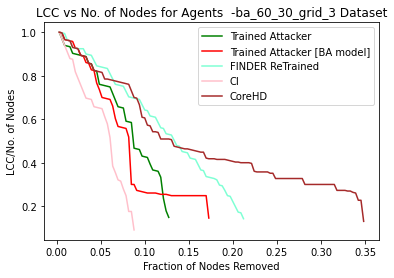

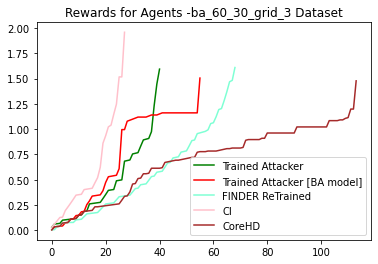

In [27]:
#file_list =['ba_60_10_house_1', 'ba_60_20_house_2', 'ba_60_30_house_3', 'ba_60_10_fan_1', 'ba_60_20_fan_2', 'ba_60_30_fan_3', 'ba_60_10_clique_1', 'ba_60_20_clique_2', 'ba_60_30_clique_3', 'ba_60_10_diamond_1', 'ba_60_20_diamond_2', 'ba_60_30_diamond_3', 'ba_60_10_cycle_1', 'ba_60_20_cycle_2', 'ba_60_30_cycle_3', 'ba_60_10_star_1', 'ba_60_20_star_2', 'ba_60_30_star_3', 'ba_60_10_grid_1', 'ba_60_20_grid_2', 'ba_60_30_grid_3']
file_list =['ba_60_10_house_1', 'ba_60_20_house_2', 'ba_60_30_house_3', 'ba_60_10_fan_1', 'ba_60_20_fan_2', 'ba_60_30_fan_3', 'ba_60_10_clique_1', 'ba_60_20_clique_2', 'ba_60_30_clique_3', 'ba_60_10_diamond_1', 'ba_60_20_diamond_2', 'ba_60_30_diamond_3', 'ba_60_10_star_1', 'ba_60_20_star_2', 'ba_60_30_star_3', 'ba_60_10_grid_1', 'ba_60_20_grid_2', 'ba_60_30_grid_3']
graph_path = "./Dataset/Validation/GNNexplanation/New/"
AUC = visual_evaluation(graph_path,file_list,[attacker[0],parameter[0]],[attacker[1],parameter[1]])

tree_4_10_house_1
[40, 7, 47, 4, 11, 13, 8, 43, 35, 41, 46, 51, 3, 12, 10, 14, 42]
[40, 18, 4, 47, 11, 2, 13, 16, 12, 43, 3, 41, 57]


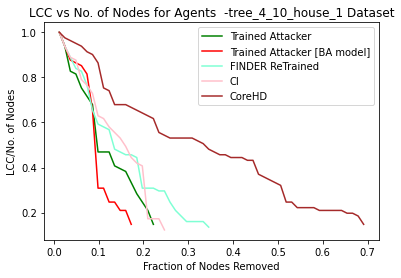

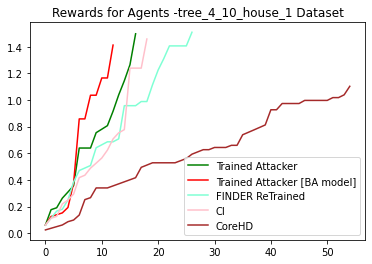

tree_4_20_house_2
[18, 26, 9, 29, 35, 16, 38, 93, 92, 14, 56, 5, 54, 51, 50, 10, 19, 46, 52, 42, 0, 7, 47, 53]
[26, 18, 23, 29, 0, 56, 20, 14, 7, 21, 17, 52, 15, 51, 19, 50, 22, 10, 16, 5]


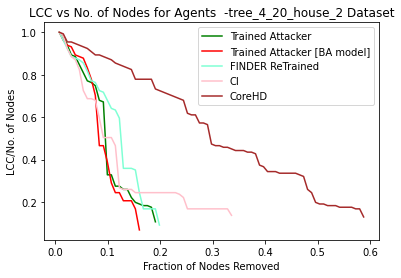

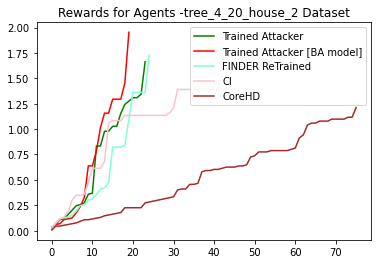

tree_4_30_house_3
[30, 20, 180, 65, 19, 6, 15, 9, 101, 24, 60, 121, 16, 113, 17, 50, 64, 11, 62, 52, 14, 56, 59, 63, 97, 61, 54, 55, 3, 48, 12, 136]
[20, 30, 65, 18, 6, 9, 19, 15, 24, 97, 52, 12, 16, 27, 17, 33, 60, 63, 50, 49, 3, 61, 57, 59, 62, 54, 55, 21, 64, 56, 1]


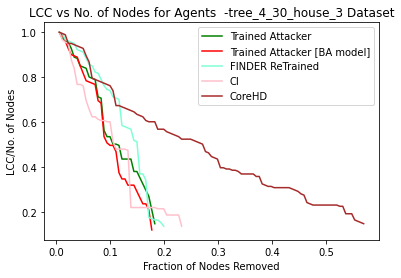

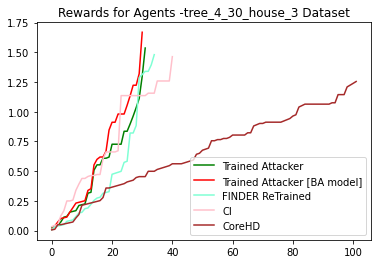

tree_4_10_fan_1
[8, 7, 14, 11, 9, 34, 12, 0]
[8, 14, 11, 7, 9, 0, 12]


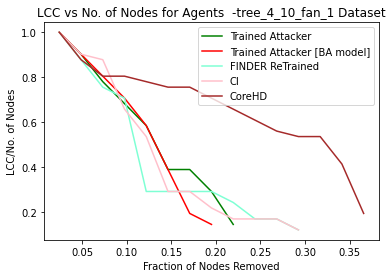

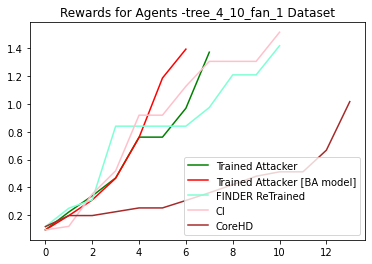

tree_4_20_fan_2
[16, 13, 19, 17, 15, 12, 18, 1, 14, 20, 11, 21, 3]
[10, 16, 1, 17, 19, 15, 12, 14, 11, 18, 20, 3]


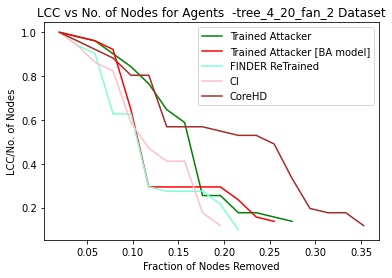

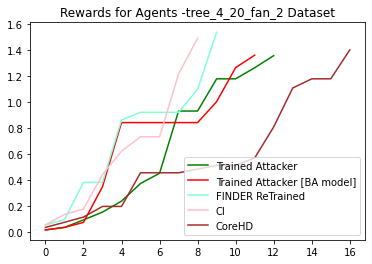

tree_4_30_fan_3
[13, 16, 10, 20, 14, 17, 1, 11, 21, 8, 3, 19]
[15, 10, 16, 13, 21, 2, 1, 19]


tree_4_10_clique_1
[3, 4, 16, 14, 11, 15, 2, 12, 6]
[3, 16, 4, 14, 11, 2, 12, 13]


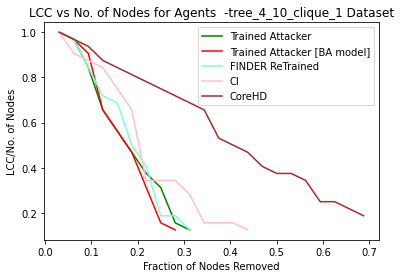

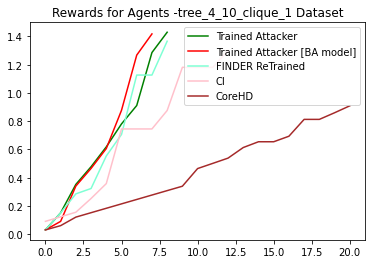

tree_4_20_clique_2
[3, 16, 9, 13, 8, 14, 11, 2, 15, 12, 0]
[3, 16, 9, 1, 2, 13, 14, 15, 11, 8, 23]


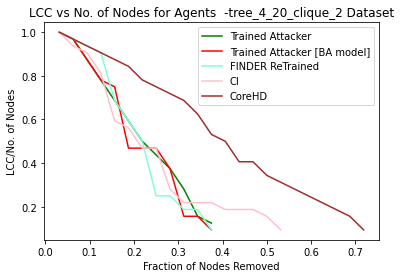

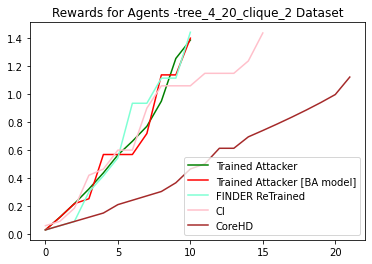

tree_4_30_clique_3
[3, 10, 13, 15, 9, 11, 1, 12, 2, 8, 6]
[3, 10, 2, 1, 16, 9, 14, 11, 8]


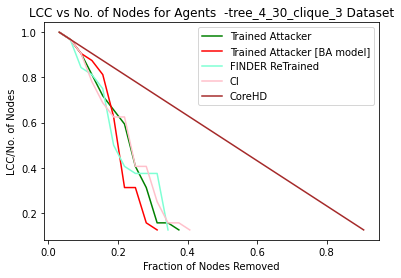

tree_4_10_diamond_1
[36, 4, 14, 43, 29, 10, 46, 70, 35, 44, 58, 20, 11, 52, 3, 75, 41, 12, 7, 47, 64, 57, 83, 90, 18, 13, 19]
[14, 65, 29, 46, 4, 43, 11, 36, 59, 10, 35, 3, 44, 41, 42, 47, 12, 8, 7]


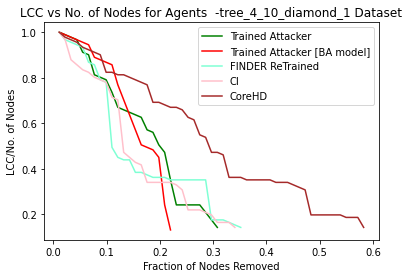

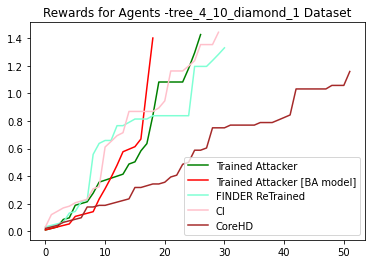

tree_4_20_diamond_2
[32, 117, 35, 85, 38, 22, 6, 3, 31, 53, 96, 108, 107, 52, 5, 63, 125, 56, 55, 66, 131, 44, 140, 49, 137, 51, 12, 84, 77, 75, 74, 48, 21, 2, 11]
[35, 6, 63, 52, 85, 22, 108, 121, 107, 31, 62, 38, 3, 76, 143, 92, 125, 53, 12, 50, 140, 54, 48, 102, 44, 51, 56, 66, 9, 49, 96, 5, 103, 18, 10, 150, 80, 15, 78, 117, 11, 21]


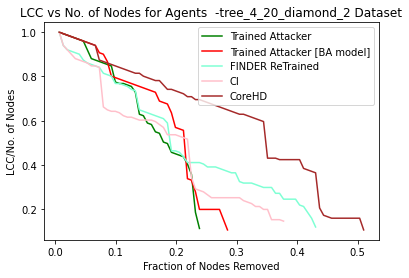

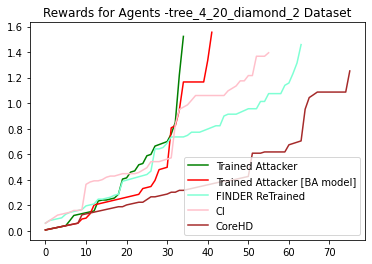

tree_4_30_diamond_3
[160, 19, 13, 29, 61, 162, 86, 63, 15, 27, 78, 18, 6, 60, 143, 45, 16, 144, 52, 8, 65, 79, 96, 12, 30, 125, 53, 101, 38, 9, 3, 69, 136, 56, 71, 55, 119, 26, 205, 70, 189, 200, 201, 17, 68, 72, 67, 145, 54, 62]
[19, 79, 78, 29, 162, 27, 61, 143, 190, 18, 15, 60, 13, 192, 63, 45, 86, 53, 201, 65, 54, 56, 52, 124, 9, 156, 69, 2, 16, 22, 12, 3, 70, 58, 23, 30, 117, 33, 42, 160, 55, 177, 71, 125, 144, 145, 103, 176, 67, 68, 133, 17, 72, 104, 88, 20, 10, 1]


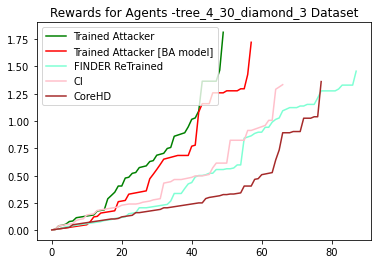

tree_4_10_cycle_1
[8, 36, 37, 7, 11, 33, 46, 47, 39, 40, 42, 41, 9, 12, 43, 1, 10, 13, 14]
[7, 8, 11, 14, 1, 9, 44]


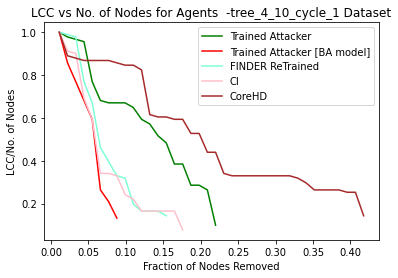

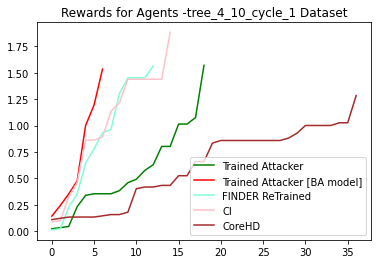

tree_4_20_cycle_2
[21, 17, 2, 14, 18, 15, 60, 4, 22, 23, 20, 19, 59, 16, 1, 3, 58, 24, 137, 55]
[17, 21, 14, 2, 1, 12, 20, 60, 11, 15]


tree_4_30_cycle_3
[7, 2, 23, 68, 69, 21, 22, 4, 67, 5, 39, 70, 66, 18, 3, 6, 187, 62, 17, 61, 53, 12, 54, 59, 35, 60, 151, 24, 52]
[2, 18, 21, 1, 12, 15, 22, 17, 14, 11, 64]


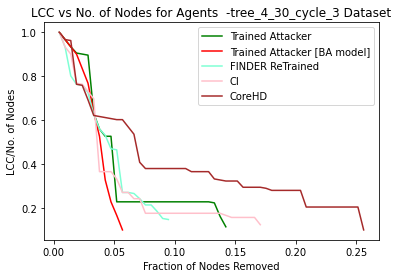

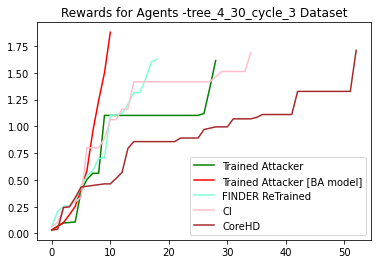

tree_4_10_star_1
[4, 15, 12, 7, 14, 22, 0]
[4, 15, 7, 12, 14, 38, 13]


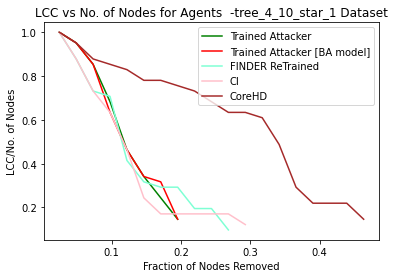

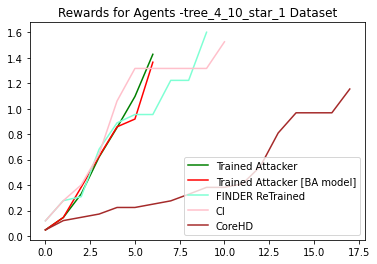

tree_4_20_star_2
[10, 19, 16, 14, 17, 1, 2, 11, 13]
[10, 19, 18, 15, 16, 14, 17, 11, 2, 13]


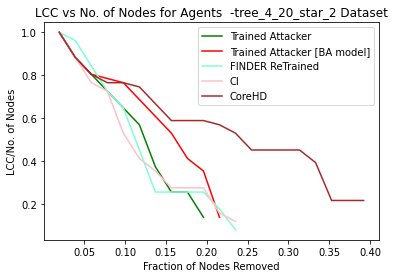

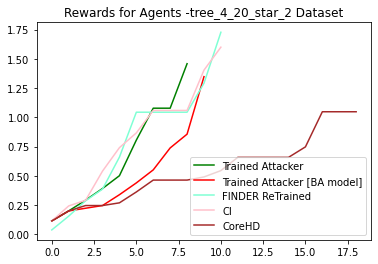

tree_4_30_star_3
[20, 10, 16, 13, 19, 14, 1, 2, 17, 21]
[20, 10, 16, 13, 2, 17, 11, 14, 1, 19, 38]


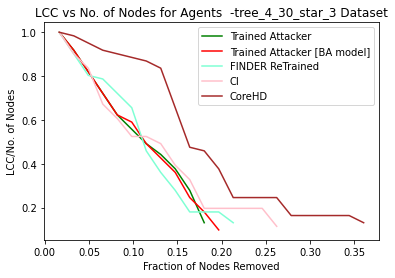

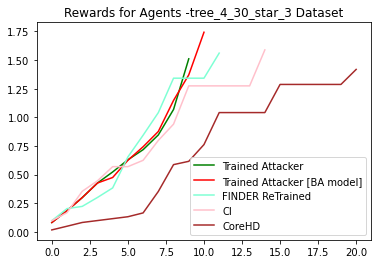

tree_4_10_grid_1
[191, 346, 342, 125, 345, 348, 275, 48, 353, 140, 276, 303, 349, 64, 11, 25, 241, 128, 36, 211, 263, 38, 231, 208, 198, 327, 46, 318, 50, 155, 60, 109, 153, 66, 302, 39, 58, 86, 386, 150, 376, 139, 382, 137, 148, 149, 145, 133, 154, 136, 7, 14, 69, 8, 9, 80, 77, 59, 53, 49, 339, 199, 45, 44, 55, 193, 185, 174, 171, 175, 170, 179, 188, 197, 258, 159, 93, 270, 123, 47, 131, 267, 251, 285, 291, 279, 287, 293, 288, 216, 365, 372, 374, 385, 239, 81, 234, 233, 162, 224, 329, 320, 307, 304, 310, 236, 91, 124, 20, 121, 104, 113, 96, 388, 373, 324, 147, 308, 190, 316, 334, 132, 206, 41, 43, 3, 151, 187, 203, 296, 325, 12, 115, 65, 366]
[125, 128, 42, 276, 140, 81, 60, 205, 258, 11, 48, 263, 145, 50, 16, 192, 327, 318, 46, 212, 208, 109, 58, 136, 231, 345, 130, 211, 106, 86, 148, 379, 251, 161, 316, 112, 377, 175, 91, 292, 118, 45, 53, 374, 131, 365, 383, 280, 321, 93, 228, 307, 120, 294, 355, 9, 185, 69, 233, 286, 267, 236, 170, 55, 96, 156, 310, 342, 159, 149, 239, 270, 77, 22

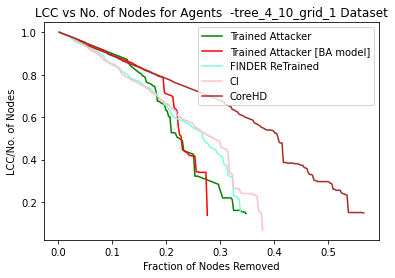

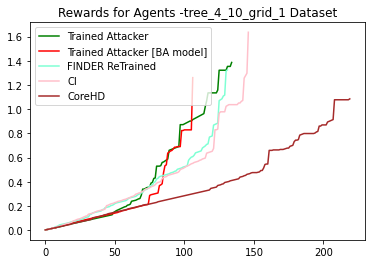

tree_4_20_grid_2
[433, 567, 702, 119, 135, 114, 426, 356, 554, 395, 108, 695, 285, 136, 130, 56, 212, 129, 546, 187, 735, 87, 401, 733, 257, 153, 443, 737, 739, 614, 508, 59, 484, 20, 102, 580, 17, 730, 152, 38, 149, 151, 14, 49, 560, 270, 177, 175, 163, 446, 142, 133, 121, 682, 221, 307, 438, 469, 52, 435, 380, 231, 605, 278, 300, 525, 103, 320, 74, 204, 76, 349, 69, 254, 550, 422, 269, 201, 348, 457, 218, 210, 224, 208, 227, 215, 226, 363, 679, 373, 678, 673, 378, 194, 720, 120, 107, 113, 125, 111, 6, 104, 118, 477, 465, 464, 474, 470, 472, 615, 743, 16, 294, 388, 485, 663, 10, 368, 19, 55, 504, 188, 563, 572, 486, 579, 13, 400, 60, 12, 197, 206, 344, 359, 192, 2, 80, 57, 392, 11, 128, 513, 708, 719, 379, 716, 668, 662, 517, 666, 63, 699, 696, 155, 651, 425, 431, 420, 335, 268, 460, 596, 688, 222, 383, 174, 397, 603, 600, 585, 512, 501, 489, 281, 273, 298, 296, 277, 274, 276, 291, 535, 94, 70, 82, 541, 544, 532, 522, 97, 266, 321, 99, 95, 79, 90, 47, 71, 493, 289, 547, 540]
[221, 121

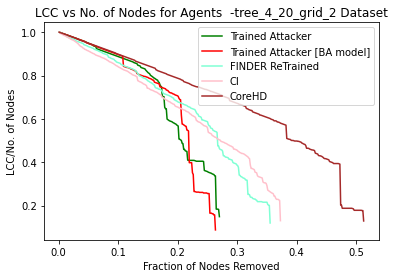

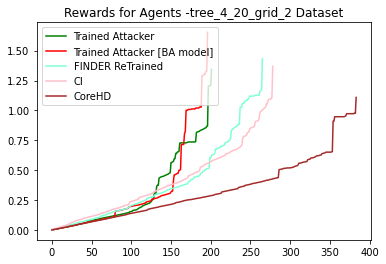

tree_4_30_grid_3
[433, 320, 1084, 185, 393, 179, 190, 184, 583, 172, 182, 174, 169, 497, 388, 576, 923, 401, 274, 164, 129, 724, 887, 356, 475, 133, 574, 230, 587, 192, 206, 715, 1080, 509, 565, 69, 499, 110, 115, 992, 93, 902, 903, 735, 732, 998, 183, 86, 437, 99, 96, 333, 102, 730, 106, 91, 92, 18, 98, 5, 593, 191, 78, 708, 719, 526, 60, 414, 135, 655, 21, 533, 542, 353, 275, 54, 188, 783, 378, 801, 71, 396, 153, 151, 381, 123, 120, 836, 741, 156, 520, 7, 251, 440, 602, 254, 612, 653, 698, 670, 525, 335, 465, 235, 1005, 302, 916, 689, 862, 376, 871, 463, 215, 225, 305, 911, 306, 447, 365, 358, 313, 472, 486, 476, 470, 1011, 217, 868, 1008, 373, 456, 1009, 46, 949, 611, 1012, 1013, 680, 1020, 1019, 1031, 1028, 1035, 478, 1024, 277, 898, 312, 298, 963, 301, 328, 310, 316, 661, 645, 658, 659, 665, 663, 667, 651, 656, 321, 409, 386, 1037, 1026, 19, 12, 467, 88, 77, 95, 368, 569, 394, 11, 1000, 995, 991, 549, 568, 578, 872, 1075, 1078, 1073, 1067, 774, 751, 22, 195, 398, 407, 405, 384, 44

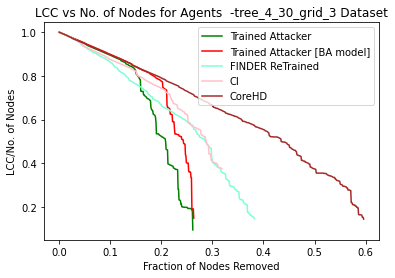

In [18]:
file_list = ['tree_4_10_house_1', 'tree_4_20_house_2', 'tree_4_30_house_3', 'tree_4_10_fan_1', 'tree_4_20_fan_2', 'tree_4_30_fan_3', 'tree_4_10_clique_1', 'tree_4_20_clique_2', 'tree_4_30_clique_3', 'tree_4_10_diamond_1', 'tree_4_20_diamond_2', 'tree_4_30_diamond_3', 'tree_4_10_cycle_1', 'tree_4_20_cycle_2', 'tree_4_30_cycle_3', 'tree_4_10_star_1', 'tree_4_20_star_2', 'tree_4_30_star_3', 'tree_4_10_grid_1', 'tree_4_20_grid_2', 'tree_4_30_grid_3']
graph_path = "./Dataset/Validation/GNNexplanation/New/"
AUC = visual_evaluation(graph_path,file_list,[attacker[0],parameter[0]],[attacker[1],parameter[1]])

In [19]:
file = ['differentGraph','BAGraph','FinderReTrained','CI','CoreHD']
print('Test Name','\t\t','Mix','\t','BA','\t','FIN','\t','CI''\t','CoreHD''\t','BEST')
for i, element in enumerate(AUC):
    for nested_tem in element:
        if isinstance(nested_tem, str): 
            print(nested_tem, end=" => \t")
        else:
            print("{:.2f}".format(nested_tem), end=" \t")
    
    best = np.argmin(np.array(element[1:]).astype(float))
    print(file[best])
    print("")
print("===============================")

Test Name 		 Mix 	 BA 	 FIN 	 CoreHD	 BEST
tree_4_10_house_1 => 	12.33 	10.75 	27.40 	BAGraph

tree_4_20_house_2 => 	14.61 	16.45 	41.99 	differentGraph

tree_4_30_house_3 => 	22.80 	19.58 	49.92 	BAGraph

tree_4_10_fan_1 => 	4.66 	4.85 	9.40 	differentGraph

tree_4_20_fan_2 => 	4.98 	5.25 	9.62 	differentGraph

tree_4_30_fan_3 => 	5.52 	6.60 	11.54 	differentGraph

tree_4_10_clique_1 => 	5.06 	6.38 	12.34 	differentGraph

tree_4_20_clique_2 => 	6.02 	6.95 	12.23 	differentGraph

tree_4_30_clique_3 => 	5.97 	6.53 	15.75 	differentGraph

tree_4_10_diamond_1 => 	15.03 	14.40 	27.93 	BAGraph

tree_4_20_diamond_2 => 	33.35 	27.84 	47.11 	BAGraph

tree_4_30_diamond_3 => 	49.70 	42.18 	54.91 	BAGraph

tree_4_10_cycle_1 => 	6.18 	5.93 	19.29 	BAGraph

tree_4_20_cycle_2 => 	9.08 	8.20 	21.61 	BAGraph

tree_4_30_cycle_3 => 	9.01 	11.21 	21.16 	differentGraph

tree_4_10_star_1 => 	4.57 	4.37 	11.13 	BAGraph

tree_4_20_star_2 => 	5.36 	5.21 	10.73 	BAGraph

tree_4_30_star_3 => 	6.07 	6.82 	10.68 

# Gene DataSet

COAD
[2612, 2605, 2610, 2313, 1429, 1462, 2376, 2381, 2084, 2088, 2089, 2090, 2092, 2093, 2094, 1465, 2096, 2098, 2820, 2101, 2107, 2109, 2112, 2115, 2123, 2124, 2126, 2065, 2531, 2378, 2377, 2314, 2306, 2382, 2800, 2803, 2804, 2808, 2809, 849, 2811, 2813, 2814, 2815, 2826, 2832, 1466, 2834, 2835, 2836, 2401, 2301, 2298, 2117, 319, 2, 8, 297, 1851, 1212, 1229, 1272, 2409, 1232, 1239, 1262, 457, 1247, 1249, 1256, 1257, 1264, 1268, 1273, 1216, 1251, 1276, 1279, 1282, 1283, 1285, 1289, 1739, 6, 1518, 1849, 182, 7, 1852, 2806, 1363, 1219, 1217, 1223, 1274, 2534, 2536, 697, 2538, 1732, 1263, 2539, 2540, 549, 1267, 1362, 1286, 1228, 1248, 1405, 682, 1234, 1225, 688, 716, 696, 684, 691, 1393, 510, 489, 495, 488, 496, 516, 518, 527, 530, 532, 533, 538, 540, 4, 711, 554, 490, 2827, 1406, 2831, 1412, 542, 5, 548, 1079, 566, 1410, 1427, 346, 168, 18, 1433, 1, 662, 998, 1091, 1633, 724, 38, 1284, 1221, 1242, 1627, 13, 229, 1237, 2496, 1628, 659, 1253, 2712, 1672, 714, 550, 388, 1847, 1848, 656, 52

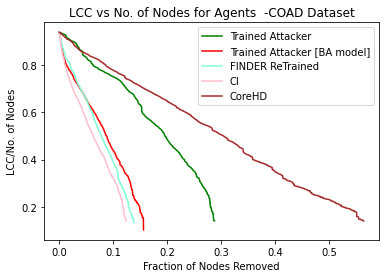

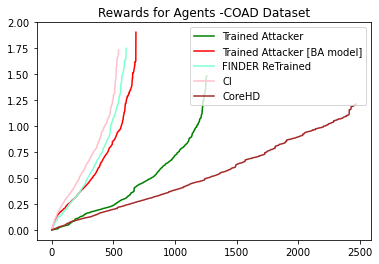

HNSC
[101, 1155, 1163, 1169, 25, 4645, 4647, 4042, 231, 27, 39, 1485, 1466, 1498, 1747, 1531, 1481, 1483, 1672, 1468, 1465, 1464, 1790, 1795, 1476, 1491, 1488, 1470, 1463, 1490, 1495, 1494, 1797, 45, 1894, 720, 1793, 1803, 2070, 1585, 1474, 1475, 1799, 1638, 1787, 1812, 1609, 1808, 1677, 1755, 1633, 1704, 1530, 2074, 1728, 1626, 1714, 1752, 2067, 1555, 1789, 1487, 1567, 1788, 1686, 1680, 1635, 1694, 1742, 1798, 1492, 1722, 1761, 1493, 1480, 13, 1479, 1784, 1687, 1627, 1670, 1702, 1286, 1756, 762, 21, 2422, 124, 1489, 1482, 1484, 1472, 147, 1273, 1727, 1668, 1681, 1774, 1595, 1469, 1602, 126, 141, 1496, 106, 118, 1781, 1767, 1610, 1636, 1707, 1620, 103, 1698, 273, 1762, 1678, 188, 3969, 2175, 1708, 1590, 1723, 380, 629, 1757, 1477, 1471, 1701, 1710, 674, 1766, 1621, 164, 1740, 1763, 281, 1497, 1703, 100, 1563, 801, 208, 1607, 754, 1473, 1579, 52, 176, 1546, 716, 1630, 843, 71, 1583, 2101, 454, 830, 1499, 1345, 1587, 130, 1734, 1768, 61, 469, 255, 193, 290, 2687, 1177, 1525, 527, 1661, 1

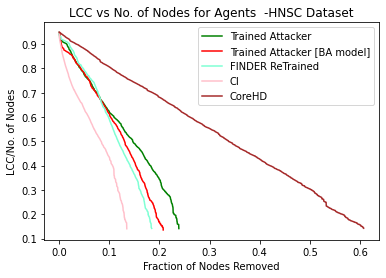

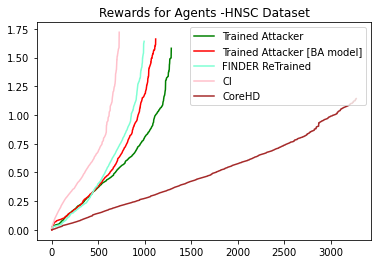

KICH
[106, 700, 139, 141, 149, 164, 187, 192, 197, 213, 256, 294, 290, 298, 198, 120, 132, 204, 267, 278, 291, 113, 140, 103, 121, 152, 790, 186, 224, 233, 773, 230, 123, 309, 194, 114, 115, 274, 124, 148, 154, 236, 137, 107, 288, 102, 150, 660, 105, 526, 501, 502, 503, 504, 506, 507, 510, 515, 517, 519, 520, 522, 531, 532, 536, 537, 539, 543, 544, 969, 546, 970, 1127, 550, 1125, 971, 368, 529, 535, 972, 549, 973, 1130, 31, 339, 387, 694, 129, 143, 1126, 273, 195, 715, 134, 147, 178, 243, 725, 342, 104, 423, 50, 687, 610, 1027, 1050, 1051, 1411, 1409, 1410, 1414, 1013, 1015, 1016, 393, 1273, 439, 394, 1018, 1613, 399, 1239, 674, 1241, 400, 145, 1242, 1243, 1244, 225, 1245, 1246, 1247, 1248, 1272, 396, 420, 72, 445, 452, 1612, 1970, 1971, 1603, 1614, 1861, 1019, 1021, 2449, 1022, 2177, 408, 804, 1956, 83, 2178, 1023, 1094, 210, 2179, 1866, 1406, 2180, 412, 417, 1967, 2030, 1884, 2448, 2353, 2450, 2469, 2604, 1026, 1029, 1571, 1611, 1276, 856, 98, 96, 1405, 1415, 414, 2523, 1249, 1332, 1

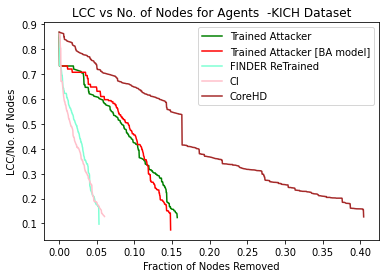

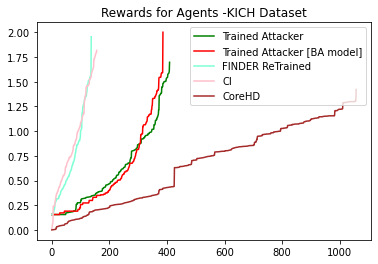

KIRC
[619, 107, 1962, 356, 41, 111, 1340, 3760, 5594, 5359, 4753, 5182, 1447, 1089, 354, 3234, 3236, 4374, 291, 248, 1983, 804, 221, 759, 4758, 2075, 1927, 1254, 334, 1281, 165, 2768, 2770, 134, 540, 2767, 4181, 2226, 159, 4169, 2108, 459, 3959, 563, 4012, 4340, 3054, 2681, 4040, 1756, 1080, 4777, 2933, 4550, 4579, 4341, 5268, 2907, 2946, 2952, 5400, 3481, 5401, 1769, 2941, 1973, 2683, 3117, 2684, 2689, 1639, 1740, 1795, 280, 1829, 1748, 1843, 1747, 277, 5882, 4343, 5301, 3957, 1709, 305, 4073, 2364, 2944, 1500, 3118, 3116, 815, 2620, 5091, 2955, 2950, 2943, 2953, 2951, 5092, 5093, 5094, 4572, 1911, 1615, 1729, 131, 3958, 4479, 3692, 3119, 5280, 794, 4484, 481, 2945, 4515, 4963, 4485, 4452, 1679, 1907, 1903, 1620, 1754, 4192, 4065, 1686, 114, 4556, 1784, 1597, 1766, 1749, 400, 4557, 48, 5951, 1848, 1819, 1763, 809, 1668, 1650, 1861, 1745, 1796, 1782, 1257, 1821, 1663, 1623, 2696, 1651, 1579, 503, 1596, 1785, 1751, 534, 1775, 1750, 1760, 1741, 1814, 1759, 1680, 132, 582, 1732, 1699, 264

FileNotFoundError: ./FINDER/FINDER_ReTrained/KIRC.txt not found.

In [20]:
graph_path = "./Dataset/GeneNetwork/"
file_list =  ["COAD","HNSC","KICH","KIRC","PRAD","UCEC"]
AUC = visual_evaluation(graph_path,file_list,[attacker[0],parameter[0]],[attacker[1],parameter[1]])
